# Project: Forecasting of Stock Volatility

## MAANG historical stock market data (2000-2023)

# About Dataset

Here You Could Get Stock Details Of These Following Companies from 2000 to 2023 . Companies are 👇

1.Microsoft

2.Apple

3.Amazon

4.Netflix

5.Google

# It contains The Following Columns 👇

1.open: Price at opening time

2.Close: Price at closing time

3.High: Highest value of that stock on that day

4.Low: Lowest value of that stock on that day

5.Adj Close : It helps in getting an idea of the fair value of a stock

6.Volume - measure of the number of stocks traded over a specified period.

7.Date - Each Date contains the stock of that company at that date .

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import optimize as sco
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [5]:
# File paths
files = {
    'Amazon': 'D:/Downloads/archive/Amazon.csv',
    'Netflix': 'D:/Downloads/archive/Netflix.csv',
    'Microsoft': 'D:/Downloads/archive/Microsoft.csv',
    'Google': 'D:/Downloads/archive/Google.csv',
    'Apple': 'D:/Downloads/archive/Apple.csv'
}

# List to hold dataframes
dfs = []

# Read each file, add the company column, and append to the list
for company, file in files.items():
    try:
        data = pd.read_csv(file)
        
        # Print columns of the dataframe to ensure it's being read correctly
        print(f"Columns in {company} data: {data.columns.tolist()}")
        
        # Add the company column
        data['Company'] = company
        
        # Append dataframe to the list
        dfs.append(data)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Check the combined DataFrame
print(df.head())




Columns in Amazon data: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
Columns in Netflix data: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
Columns in Microsoft data: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
Columns in Google data: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
Columns in Apple data: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']
       Open      High       Low     Close  Adj Close     Volume        Date  \
0  4.075000  4.478125  3.952344  4.468750   4.468750  322352000  2000-01-03   
1  4.268750  4.575000  4.087500  4.096875   4.096875  349748000  2000-01-04   
2  3.525000  3.756250  3.400000  3.487500   3.487500  769148000  2000-01-05   
3  3.565625  3.634375  3.200000  3.278125   3.278125  375040000  2000-01-06   
4  3.350000  3.525000  3.309375  3.478125   3.478125  210108000  2000-01-07   

  Company  
0  Amazon  
1  Amazon  
2  Amazon  
3  Amazon  
4  Amazon  


In [6]:
df.head()

Open      High       Low     Close  Adj Close     Volume        Date  \
0  4.075000  4.478125  3.952344  4.468750   4.468750  322352000  2000-01-03   
1  4.268750  4.575000  4.087500  4.096875   4.096875  349748000  2000-01-04   
2  3.525000  3.756250  3.400000  3.487500   3.487500  769148000  2000-01-05   
3  3.565625  3.634375  3.200000  3.278125   3.278125  375040000  2000-01-06   
4  3.350000  3.525000  3.309375  3.478125   3.478125  210108000  2000-01-07   

  Company  
0  Amazon  
1  Amazon  
2  Amazon  
3  Amazon  
4  Amazon

In [7]:
df.tail()

Open        High         Low       Close   Adj Close    Volume  \
27430  147.809998  153.139999  147.699997  150.470001  150.470001  84457100   
27431  151.279999  153.399994  150.100006  152.589996  152.589996  73695900   
27432  151.190002  153.250000  149.919998  152.990005  152.990005  77167900   
27433  152.160004  156.460007  151.639999  155.850006  155.850006  76161100   
27434  156.080002  156.740005  154.279999  155.000000  155.000000  98862500   

             Date Company  
27430  2023-03-13   Apple  
27431  2023-03-14   Apple  
27432  2023-03-15   Apple  
27433  2023-03-16   Apple  
27434  2023-03-17   Apple

In [8]:
df.shape

(27435, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27435 entries, 0 to 27434
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       27435 non-null  float64
 1   High       27435 non-null  float64
 2   Low        27435 non-null  float64
 3   Close      27435 non-null  float64
 4   Adj Close  27435 non-null  float64
 5   Volume     27435 non-null  int64  
 6   Date       27435 non-null  object 
 7   Company    27435 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
df.describe().T

count          mean           std            min           25%  \
Open       27435.0  5.885031e+01  9.475986e+01       0.231964  6.193393e+00   
High       27435.0  5.960774e+01  9.608015e+01       0.235536  6.294286e+00   
Low        27435.0  5.806866e+01  9.335733e+01       0.227143  6.081964e+00   
Close      27435.0  5.885946e+01  9.474907e+01       0.234286  6.193964e+00   
Adj Close  27435.0  5.715942e+01  9.494110e+01       0.199405  5.775902e+00   
Volume     27435.0  1.490146e+08  2.417300e+08  158434.000000  2.816100e+07   

                    50%           75%           max  
Open       2.600000e+01  5.992611e+01  6.923500e+02  
High       2.630500e+01  6.045550e+01  7.009900e+02  
Low        2.569000e+01  5.938209e+01  6.860900e+02  
Close      2.599000e+01  6.000918e+01  6.916900e+02  
Adj Close  1.969951e+01  5.902082e+01  6.916900e+02  
Volume     6.861200e+07  1.519560e+08  7.421641e+09

In [11]:
df.duplicated().sum()

0

In [12]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
Company      0
dtype: int64

In [13]:
df.nunique()

Open         22487
High         22300
Low          22377
Close        22900
Adj Close    25367
Volume       26810
Date          5839
Company          5
dtype: int64

In [14]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date',
       'Company'],
      dtype='object')

In [16]:
df['Date'] = pd.to_datetime(df['Date'])

In [16]:
# Display basic statistics for each feature
print("Descriptive statistics for each feature:")
print(df.describe(include='all'))  

Descriptive statistics for each feature:
                Open          High           Low         Close     Adj Close  \
count   27435.000000  27435.000000  27435.000000  27435.000000  27435.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       58.850310     59.607743     58.068658     58.859463     57.159425   
min         0.231964      0.235536      0.227143      0.234286      0.199405   
25%         6.193393      6.294286      6.081964      6.193964      5.775902   
50%        26.000000     26.305000     25.690001     25.990000     19.699512   
75%        59.926105     60.455500     59.382093     60.009178     59.020823   
max       692.349976    700.989990    686.090027    691.690002    691.690002   
std        94.759862     96.080148     93.357334     94.749066     94.941099   

# Exploratory Data Analysis

# Distributions for each numeric feature

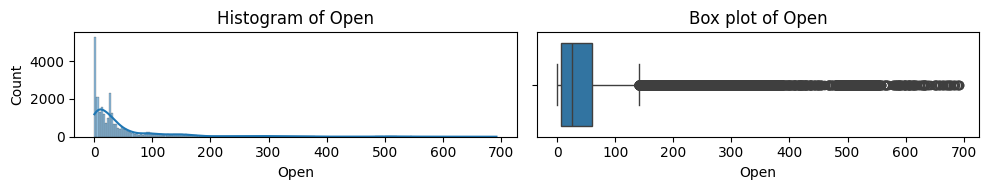

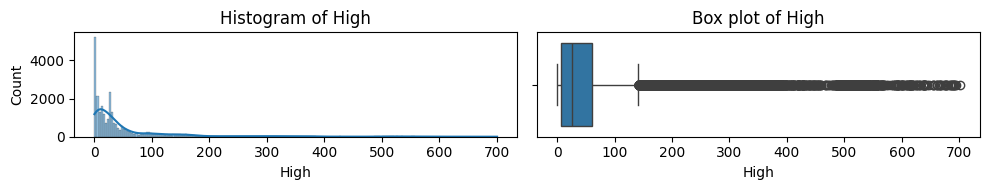

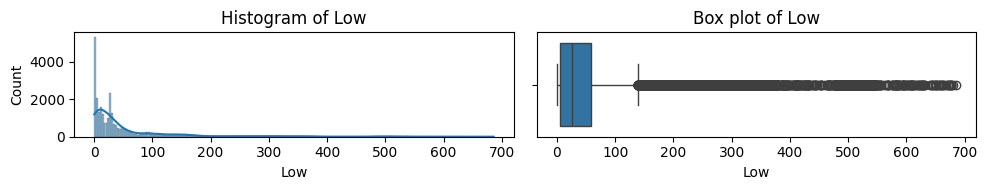

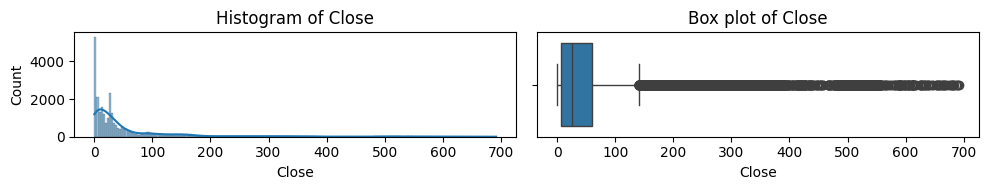

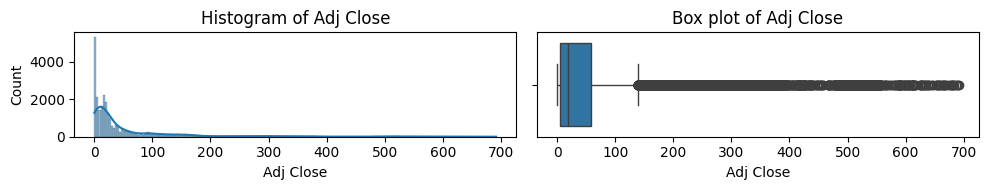

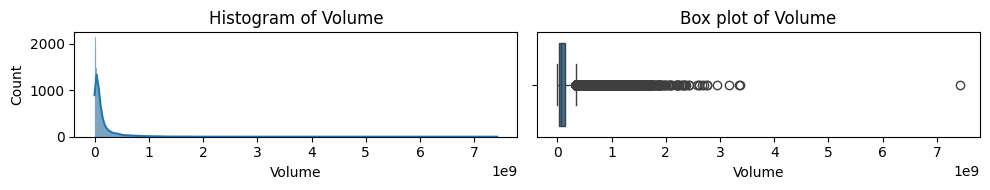

In [17]:
# Plot distributions for each numeric feature
numeric_features = df.select_dtypes(include=['number']).columns
for feature in numeric_features:
    plt.figure(figsize=(10, 2))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature].dropna(), kde=True)
    plt.title(f'Histogram of {feature}')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature].dropna())
    plt.title(f'Box plot of {feature}')
    
    plt.tight_layout()
    plt.show()

In [17]:
# Set 'Date' as the index for time series plots
df.set_index('Date', inplace=True)

In [19]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company'], dtype='object')

# Time Series Analysis of Stock Data: Trends, Prices, and Volume

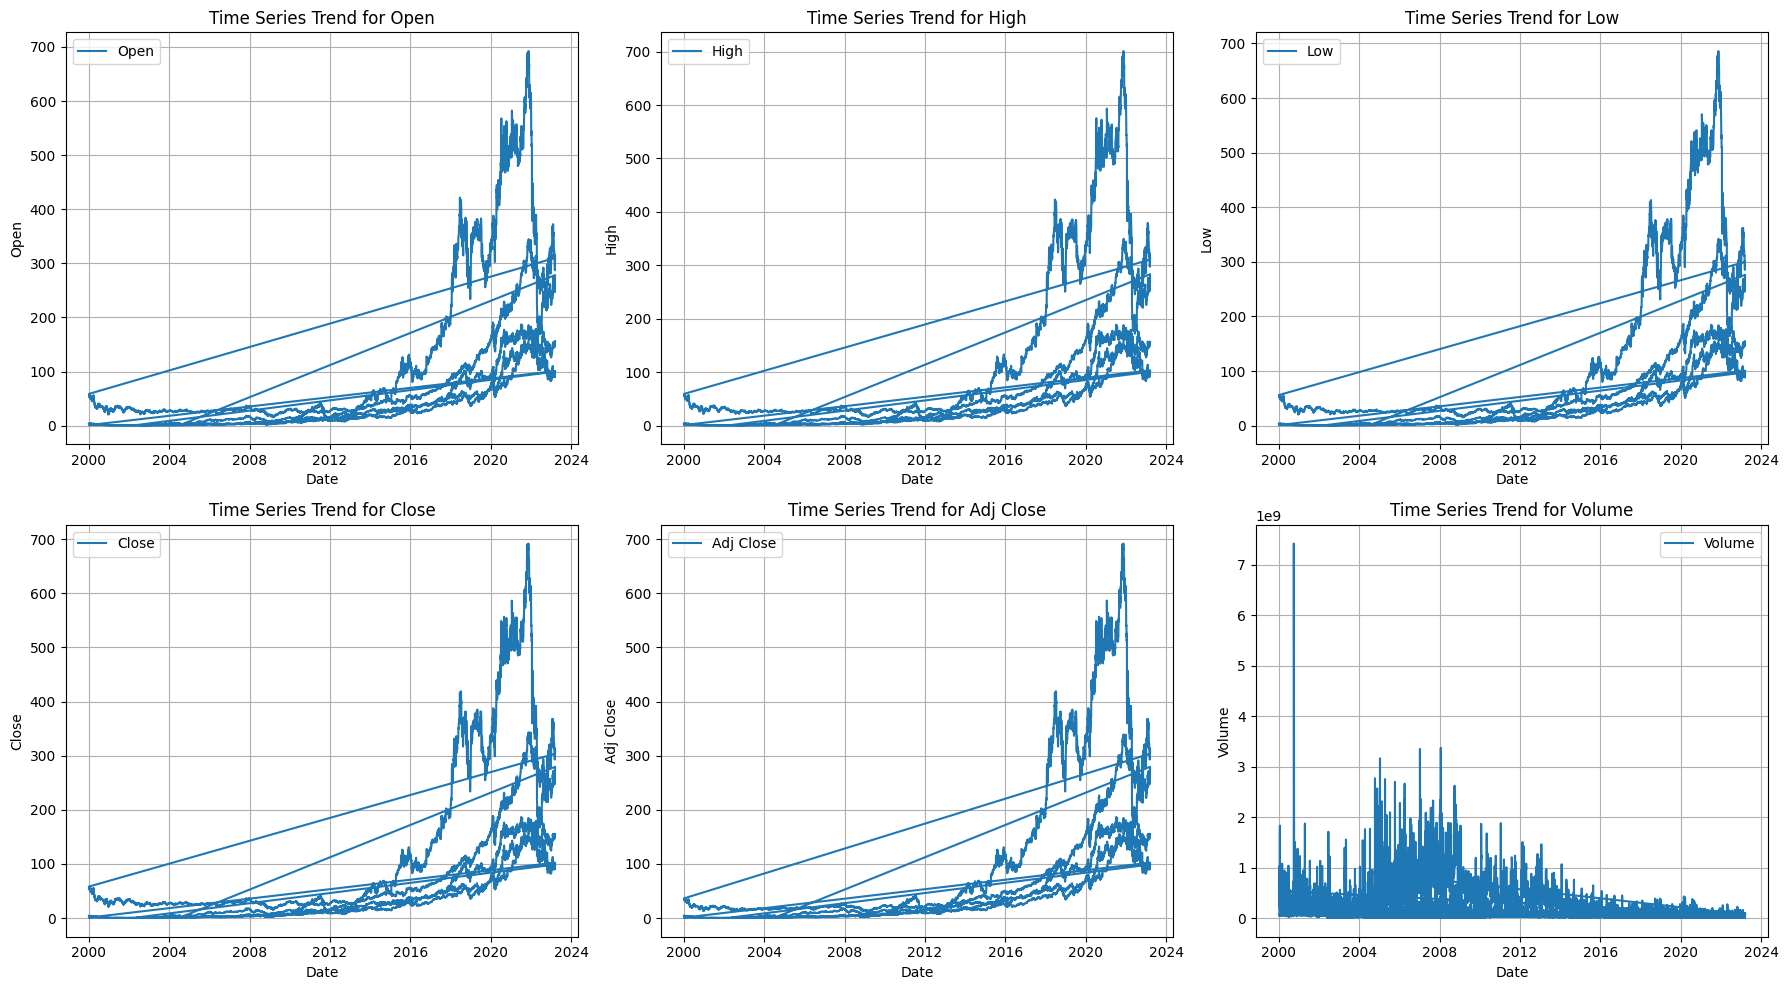

In [20]:
columns_to_plot = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df.index, df[column], label=column)
    axes[i].set_title(f'Time Series Trend for {column}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Time Series Analysis of Stock Data by Company: Trends, Prices, and Volume

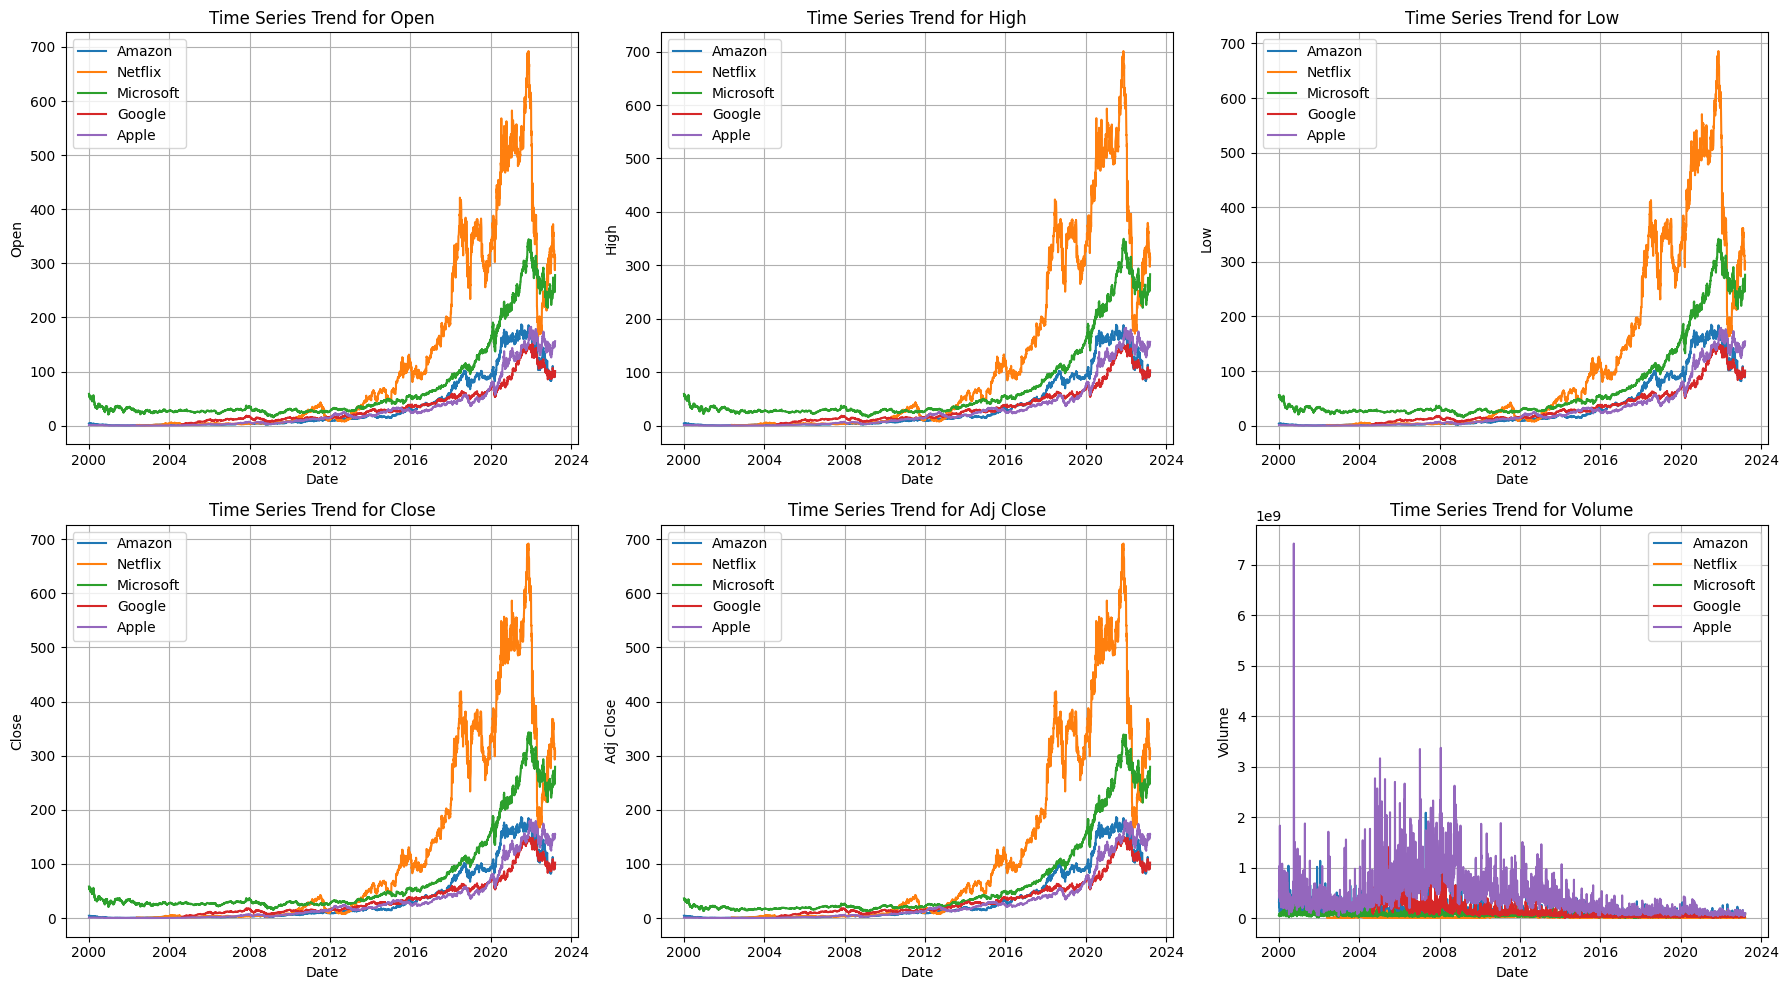

In [21]:
# Define columns to plot
columns_to_plot = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    for company in df['Company'].unique():
        company_df = df[df['Company'] == company]
        ax.plot(company_df.index, company_df[column], label=company)
    ax.set_title(f'Time Series Trend for {column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Stock Price and Moving Averages by Company: 20-Day SMA and EMA

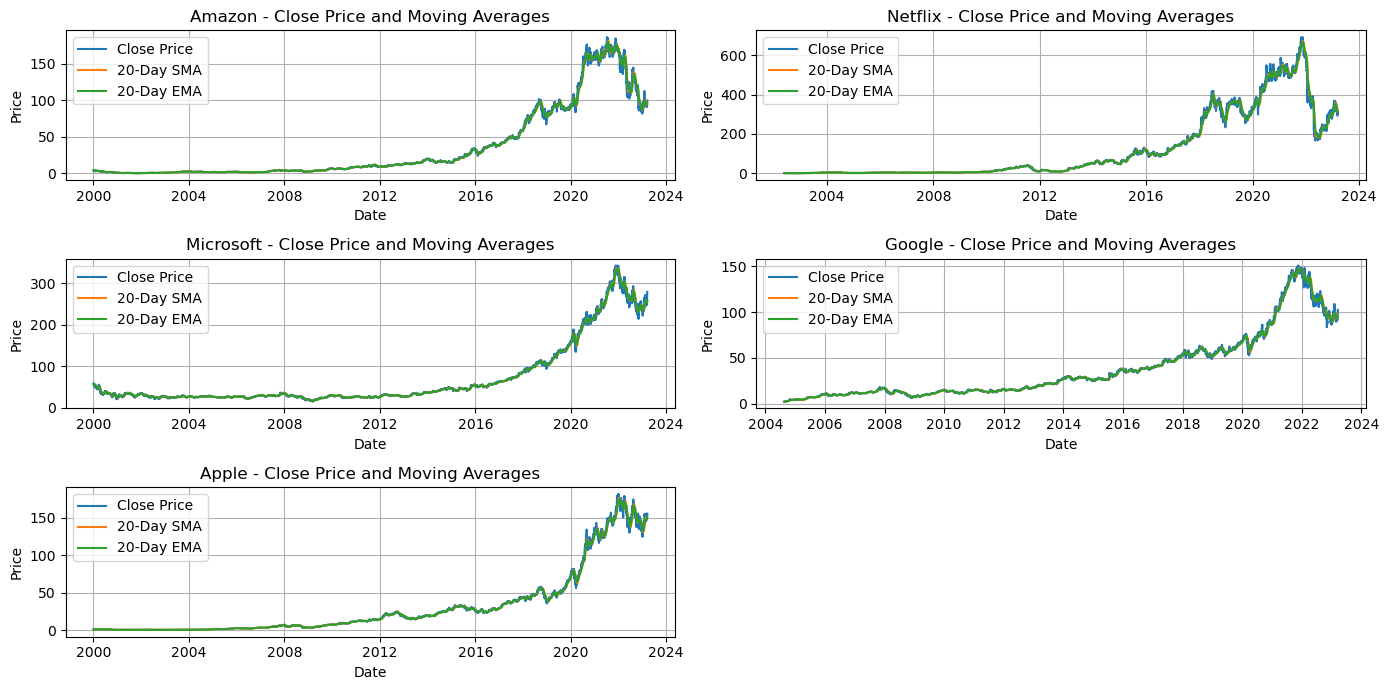

In [13]:
unique_companies = df['Company'].unique()
num_companies = len(unique_companies)

fig, axes = plt.subplots(3, 2, figsize=(14, 7))
axes = axes.flatten() 

for i, company in enumerate(unique_companies):
    company_df = df[df['Company'] == company]
    company_df['SMA_20'] = company_df['Close'].rolling(window=20).mean()
    company_df['EMA_20'] = company_df['Close'].ewm(span=20, adjust=False).mean()
    
    ax = axes[i]
    ax.plot(company_df.index, company_df['Close'], label='Close Price')
    ax.plot(company_df.index, company_df['SMA_20'], label='20-Day SMA')
    ax.plot(company_df.index, company_df['EMA_20'], label='20-Day EMA')
    ax.set_title(f'{company} - Close Price and Moving Averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Hide any empty subplots if there are fewer than 6 companies
for j in range(num_companies, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Open Price and Moving Averages by Company: 20-Day SMA and EMA

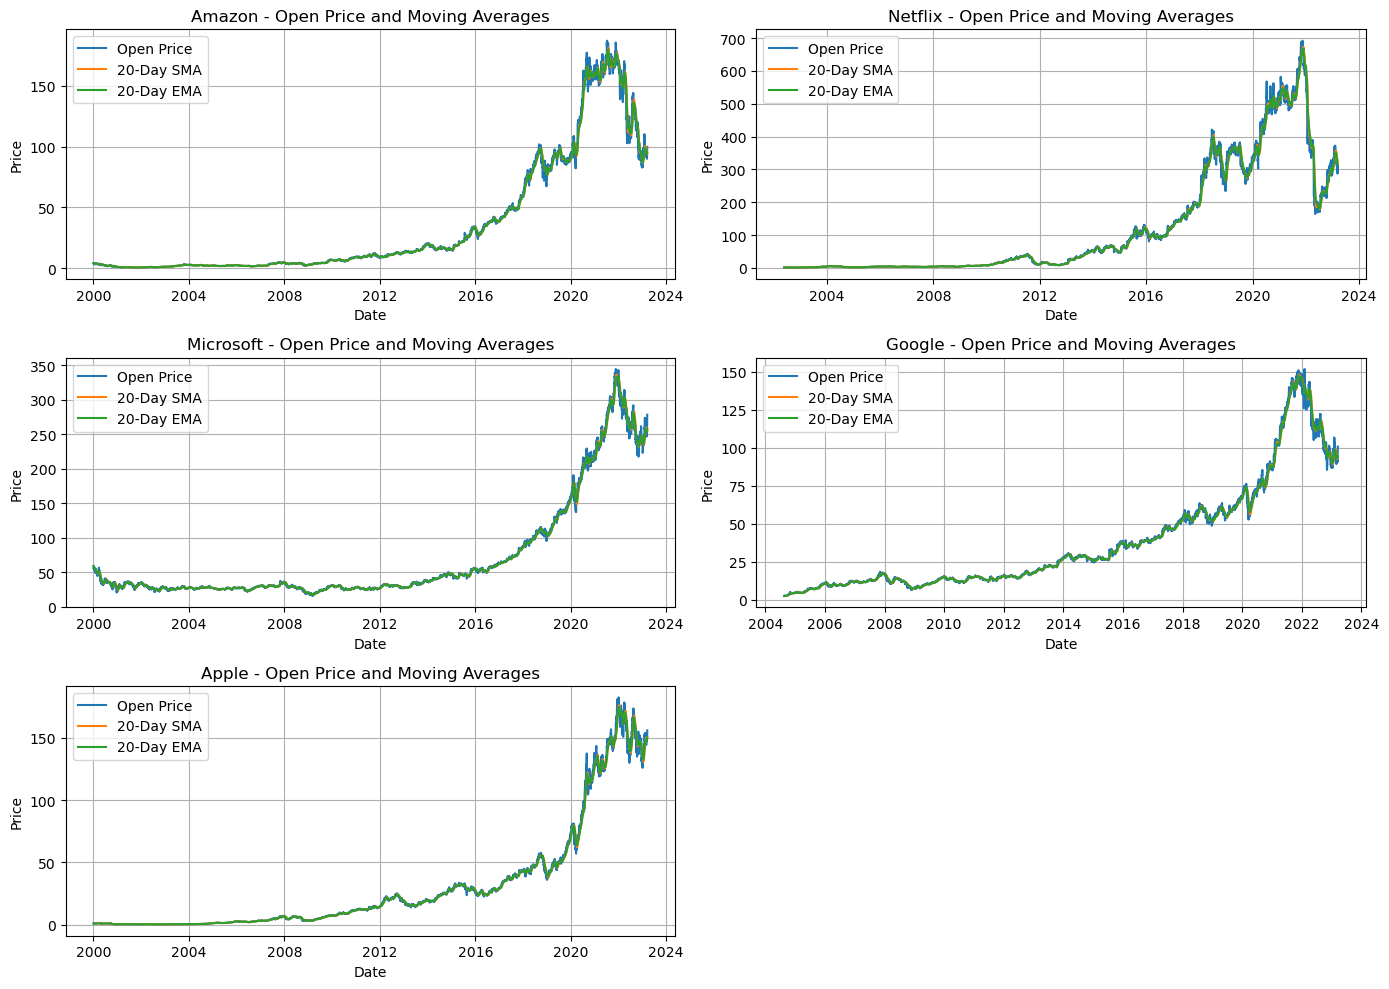

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()  

for i, company in enumerate(unique_companies):
    company_df = df[df['Company'] == company]
    company_df['SMA_20'] = company_df['Open'].rolling(window=20).mean()
    company_df['EMA_20'] = company_df['Open'].ewm(span=20, adjust=False).mean()
    
    ax = axes[i]
    ax.plot(company_df.index, company_df['Open'], label='Open Price')
    ax.plot(company_df.index, company_df['SMA_20'], label='20-Day SMA')
    ax.plot(company_df.index, company_df['EMA_20'], label='20-Day EMA')
    ax.set_title(f'{company} - Open Price and Moving Averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

for j in range(num_companies, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# High Price and Moving Averages by Company: 20-Day SMA and EMA

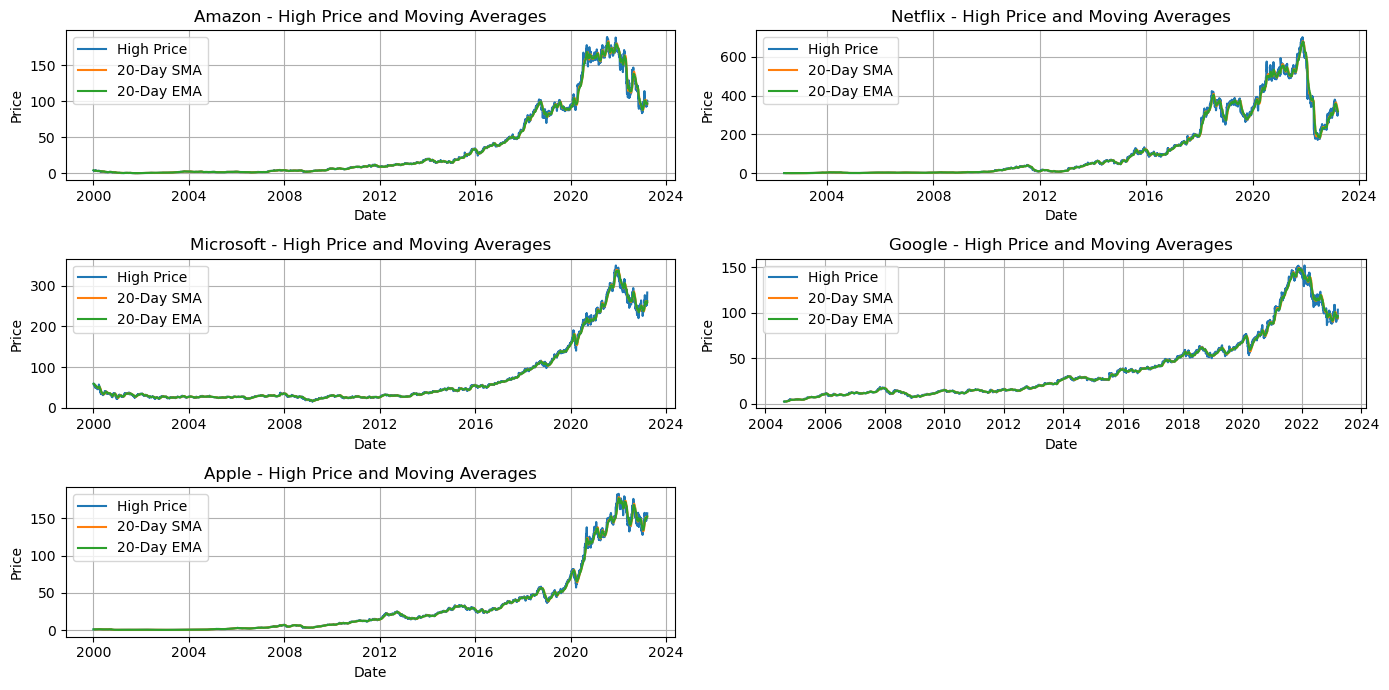

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(14, 7))
axes = axes.flatten() 

for i, company in enumerate(unique_companies):
    company_df = df[df['Company'] == company]
    company_df['SMA_20'] = company_df['High'].rolling(window=20).mean()
    company_df['EMA_20'] = company_df['High'].ewm(span=20, adjust=False).mean()
    
    ax = axes[i]
    ax.plot(company_df.index, company_df['High'], label='High Price')
    ax.plot(company_df.index, company_df['SMA_20'], label='20-Day SMA')
    ax.plot(company_df.index, company_df['EMA_20'], label='20-Day EMA')
    ax.set_title(f'{company} - High Price and Moving Averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

for j in range(num_companies, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Low Price and Moving Averages by Company: 20-Day SMA and EMA

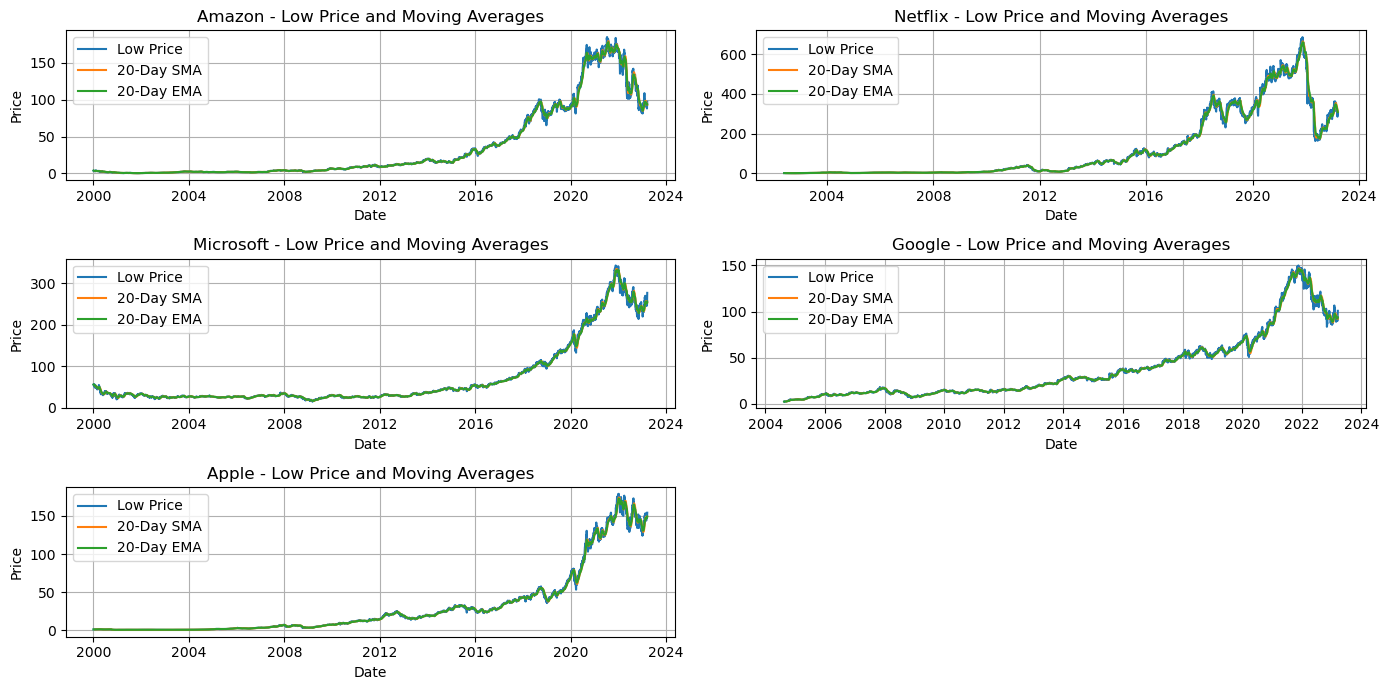

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(14, 7))
axes = axes.flatten()  

for i, company in enumerate(unique_companies):
    company_df = df[df['Company'] == company]
    company_df['SMA_20'] = company_df['Low'].rolling(window=20).mean()
    company_df['EMA_20'] = company_df['Low'].ewm(span=20, adjust=False).mean()
    
    ax = axes[i]
    ax.plot(company_df.index, company_df['Low'], label='Low Price')
    ax.plot(company_df.index, company_df['SMA_20'], label='20-Day SMA')
    ax.plot(company_df.index, company_df['EMA_20'], label='20-Day EMA')
    ax.set_title(f'{company} - Low Price and Moving Averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

for j in range(num_companies, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Trading Volume and Moving Averages by Company: 20-Day SMA and EMA

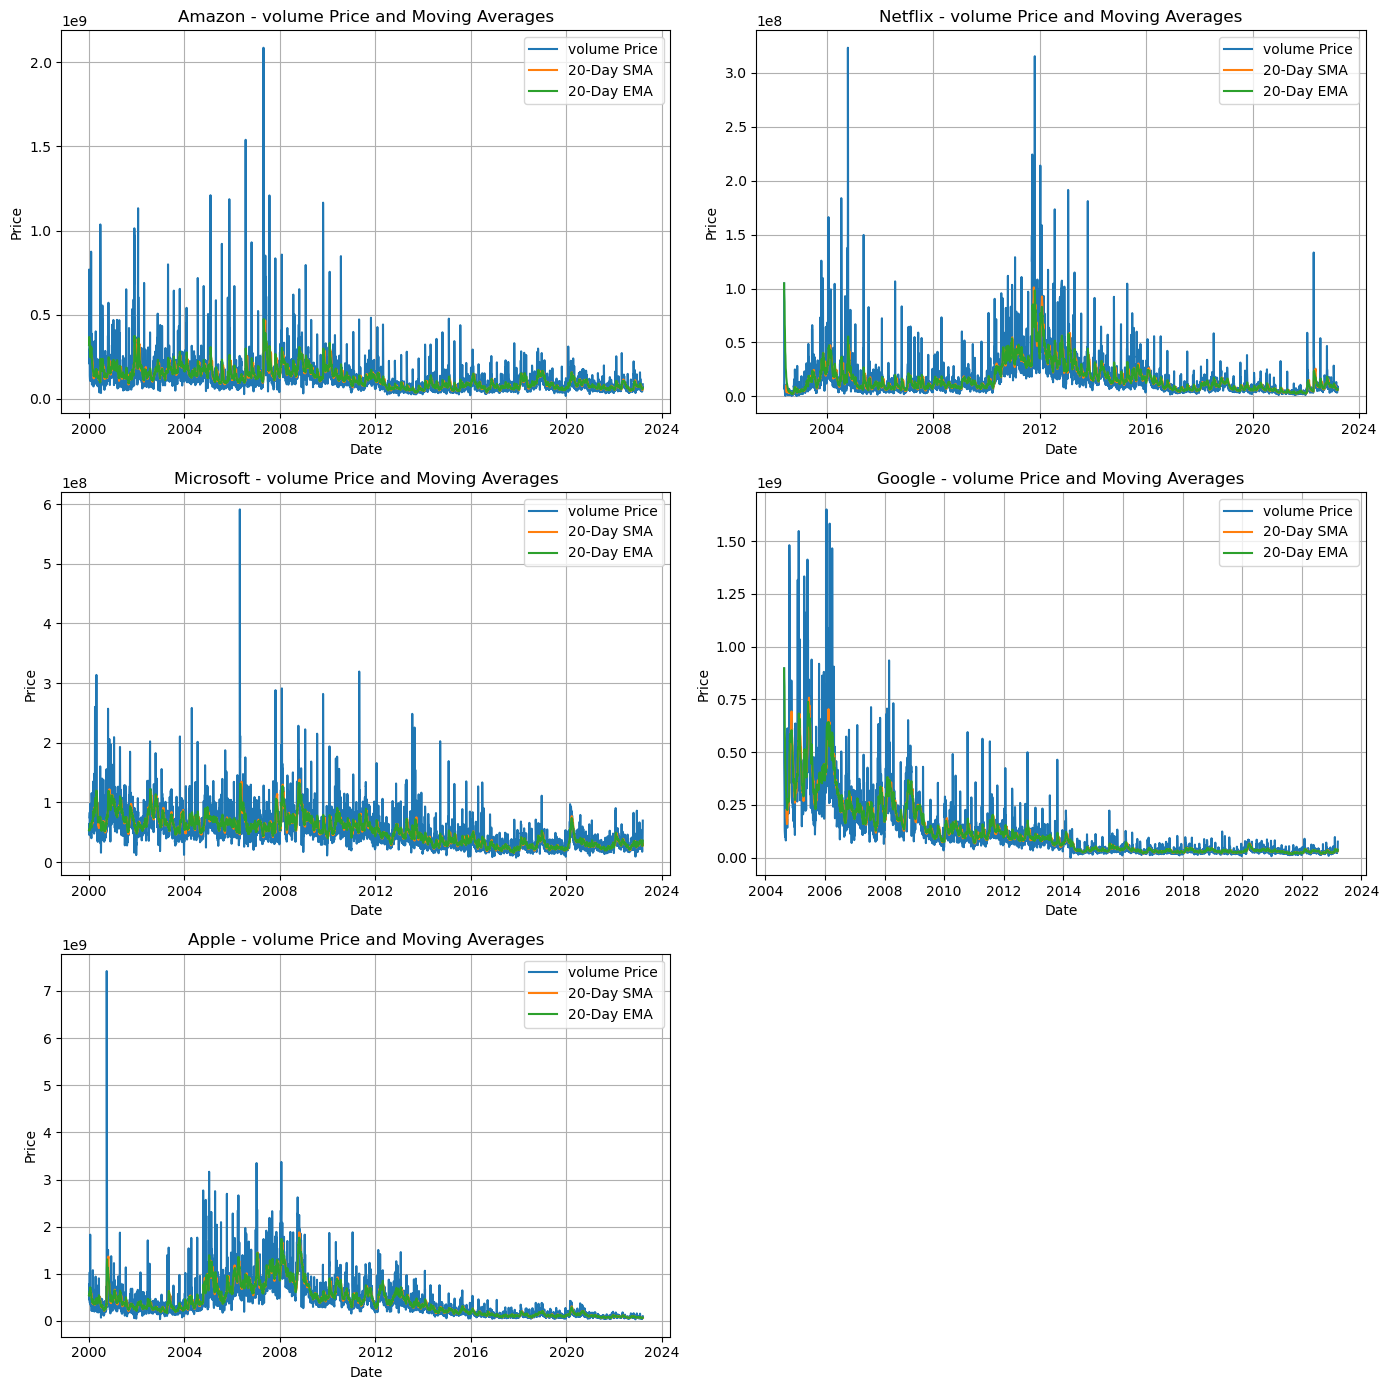

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten() 

for i, company in enumerate(unique_companies):
    company_df = df[df['Company'] == company]
    company_df['SMA_20'] = company_df['Volume'].rolling(window=20).mean()
    company_df['EMA_20'] = company_df['Volume'].ewm(span=20, adjust=False).mean()
    
    ax = axes[i]
    ax.plot(company_df.index, company_df['Volume'], label='volume Price')
    ax.plot(company_df.index, company_df['SMA_20'], label='20-Day SMA')
    ax.plot(company_df.index, company_df['EMA_20'], label='20-Day EMA')
    ax.set_title(f'{company} - volume Price and Moving Averages')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

for j in range(num_companies, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Print the index labels
print("Index labels:")
print(df.index.names)

Index labels:
['Date']


In [18]:
# Reset the index but keep the current index as a column in the DataFrame
df = df.reset_index()

In [19]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Company'],
      dtype='object')

# Bollinger Bands and Volatility Analysis for Each Company

In [20]:
# Define the rolling window size
window = 20

# Calculate SMA, Bollinger Bands, and Volatility
df['SMA'] = df.groupby('Company')['Close'].rolling(window=window, min_periods=window).mean().reset_index(level=0, drop=True)
df['Rolling_Std'] = df.groupby('Company')['Close'].rolling(window=window, min_periods=window).std().reset_index(level=0, drop=True)
df['Bollinger_Upper'] = df['SMA'] + (df['Rolling_Std'] * 2)
df['Bollinger_Lower'] = df['SMA'] - (df['Rolling_Std'] * 2)

# View for each company
for company in df['Company'].unique():
    company_df = df[df['Company'] == company]
    print(f"\n{company} - Bollinger Bands Information:")
    print(company_df[['Close', 'SMA', 'Bollinger_Upper', 'Bollinger_Lower']].head(30))

    print(f"\n{company} - Volatility:")
    print(company_df[['Rolling_Std']].head(30))


Amazon - Bollinger Bands Information:
       Close       SMA  Bollinger_Upper  Bollinger_Lower
0   4.468750       NaN              NaN              NaN
1   4.096875       NaN              NaN              NaN
2   3.487500       NaN              NaN              NaN
3   3.278125       NaN              NaN              NaN
4   3.478125       NaN              NaN              NaN
5   3.459375       NaN              NaN              NaN
6   3.337500       NaN              NaN              NaN
7   3.178125       NaN              NaN              NaN
8   3.296875       NaN              NaN              NaN
9   3.212500       NaN              NaN              NaN
10  3.206250       NaN              NaN              NaN
11  3.340625       NaN              NaN              NaN
12  3.237500       NaN              NaN              NaN
13  3.103125       NaN              NaN              NaN
14  3.506250       NaN              NaN              NaN
15  3.462500       NaN              NaN          

# Cumulative Returns Over Time by Company

In [21]:
df.set_index('Date', inplace=True)

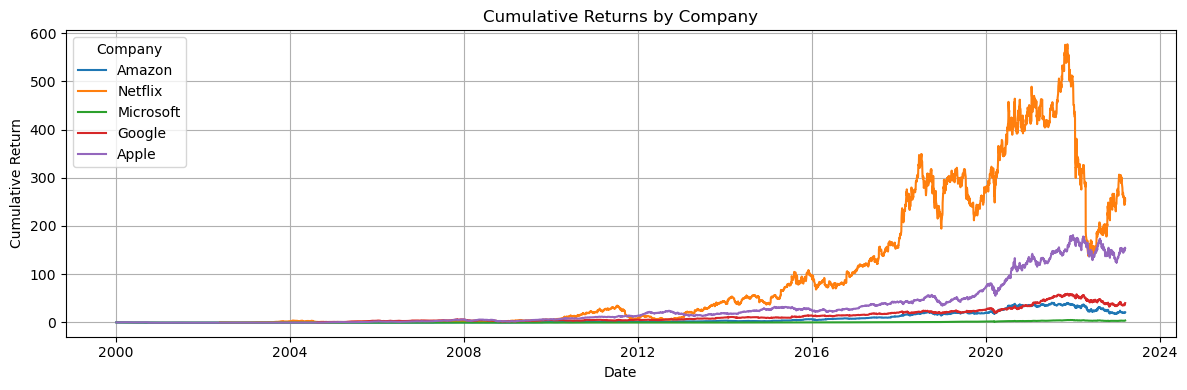

In [22]:
# Calculate daily returns
df['Daily_Return'] = df.groupby('Company')['Close'].pct_change()

# Calculate cumulative returns
df['Cumulative_Return'] = (1 + df['Daily_Return']).groupby(df['Company']).cumprod() - 1

# Plot cumulative returns by company
plt.figure(figsize=(12, 4))
for company in df['Company'].unique():
    company_data = df[df['Company'] == company]
    plt.plot(company_data.index, company_data['Cumulative_Return'], label=company)

plt.title('Cumulative Returns by Company')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Company')
plt.grid(True)
plt.tight_layout()
plt.show()


# Pairwise Correlation of Daily Returns Across Companies

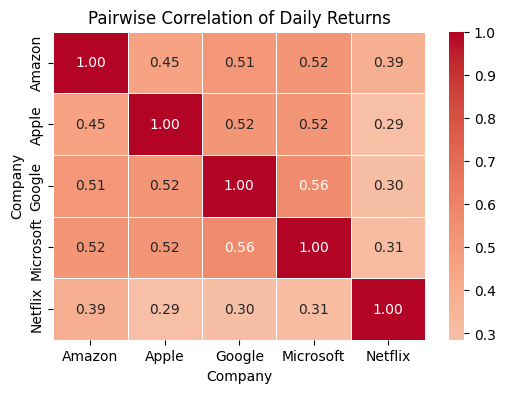

In [15]:
# Calculate daily returns
df['Daily_Return'] = df.groupby('Company')['Close'].pct_change()

# Pivot the DataFrame to have dates as index and companies as columns
returns_df = df.pivot_table(index='Date', columns='Company', values='Daily_Return')

# Drop rows with NaN values 
returns_df.dropna(inplace=True)

# Calculate the correlation matrix
correlation_matrix = returns_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Pairwise Correlation of Daily Returns')
plt.show()


# Seasonal Decomposition of Time Series for Each Company: Trend, Seasonal, and Residual Components

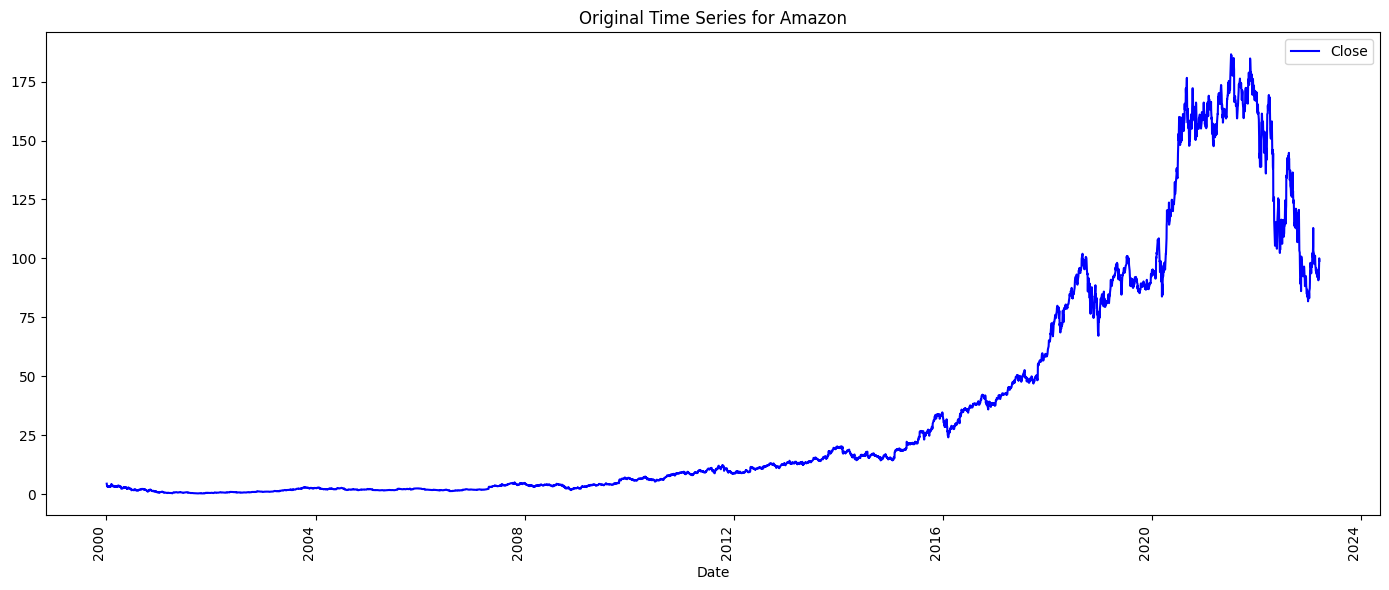

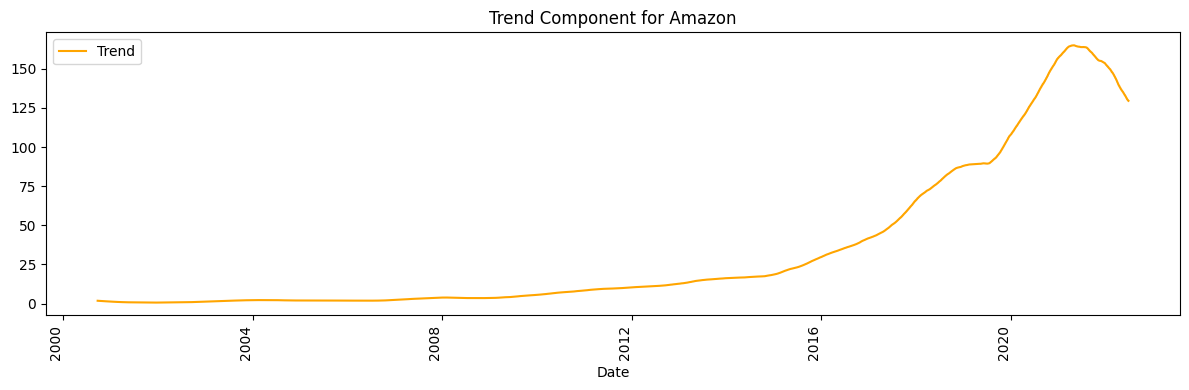

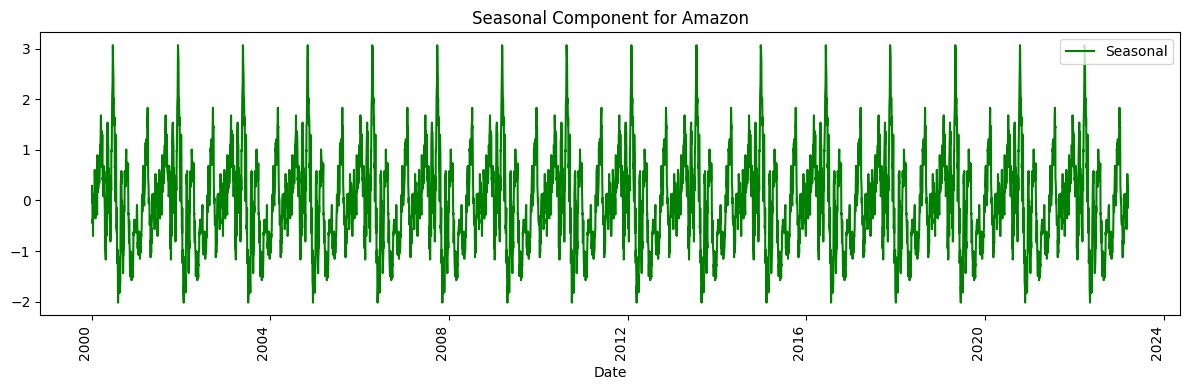

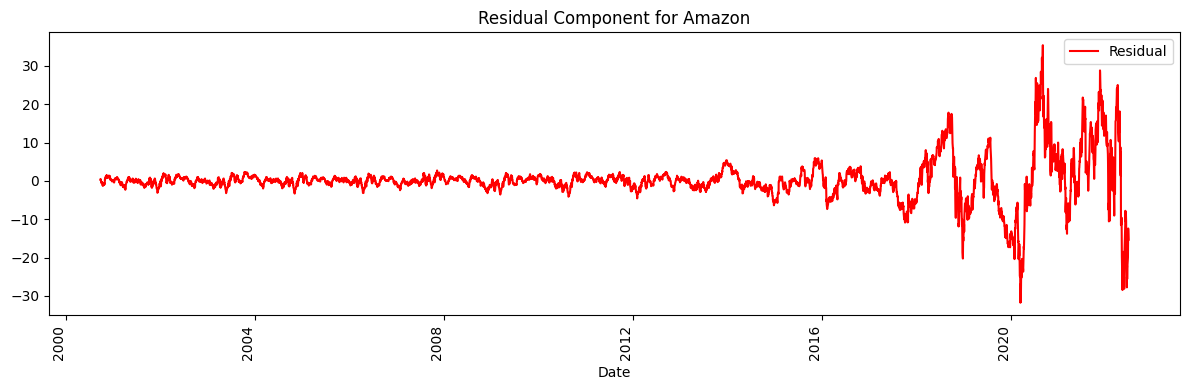

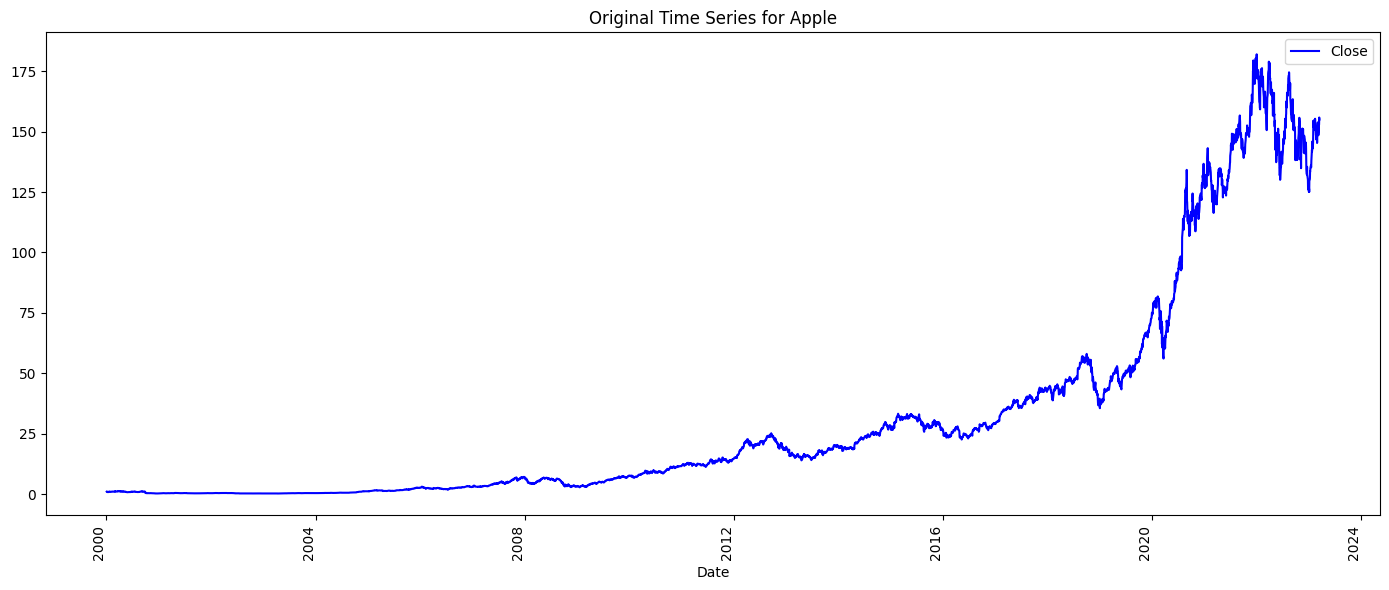

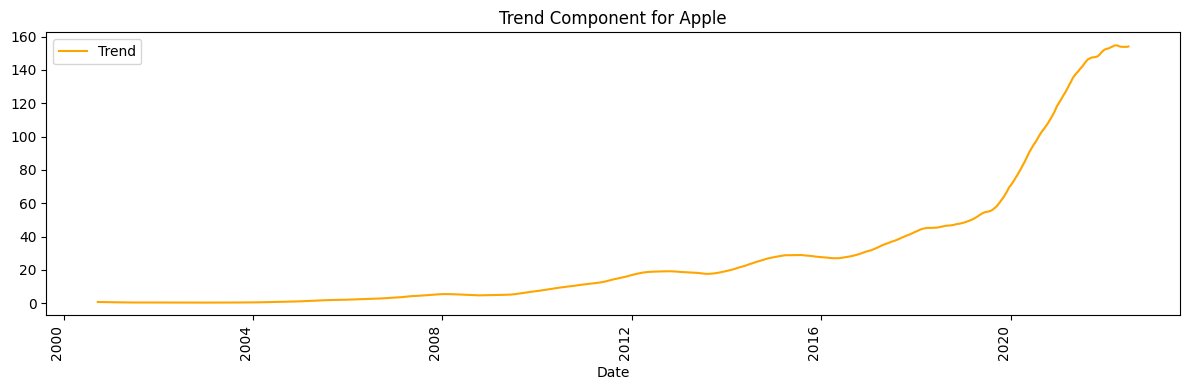

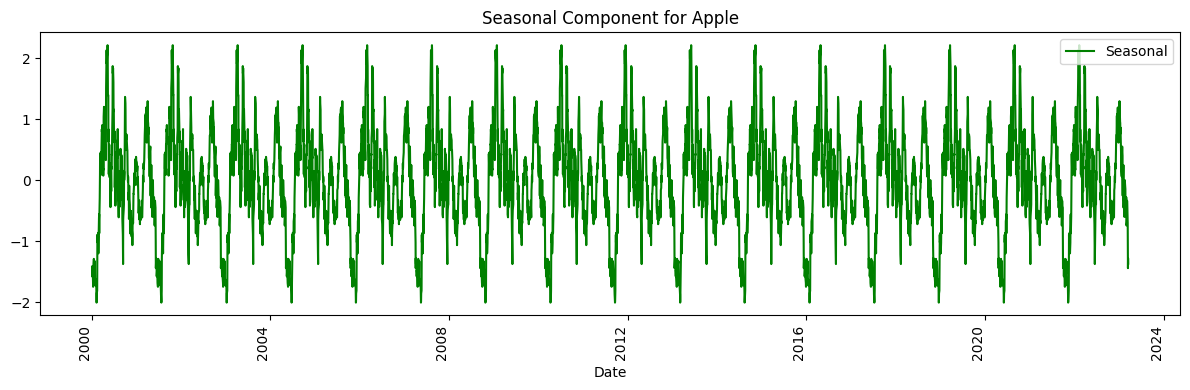

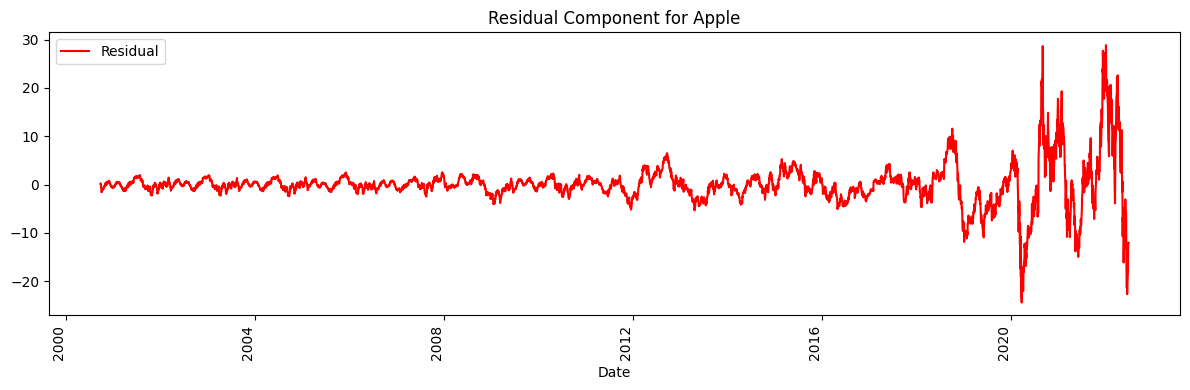

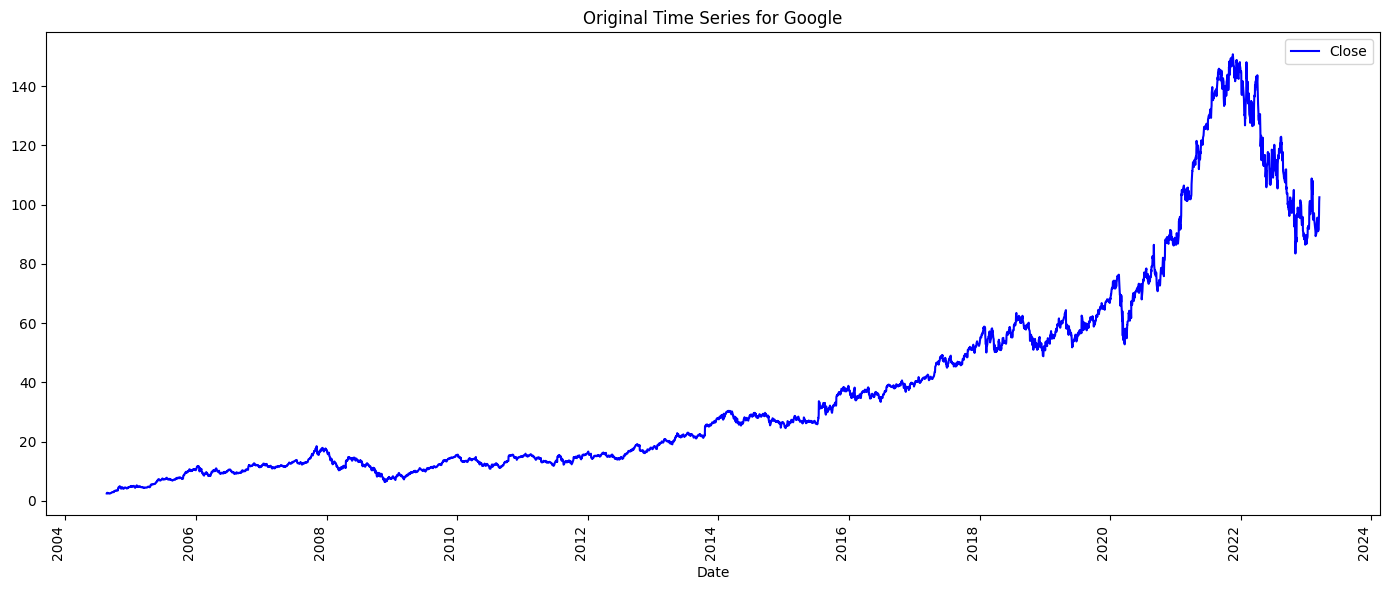

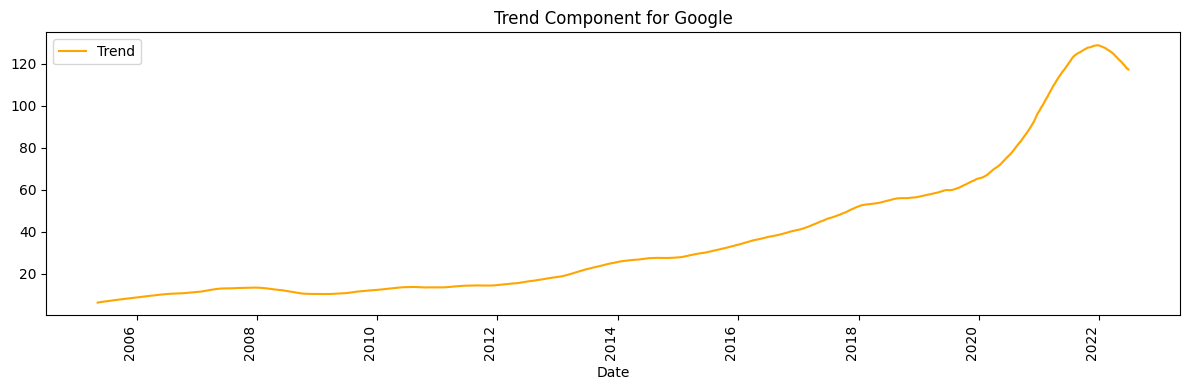

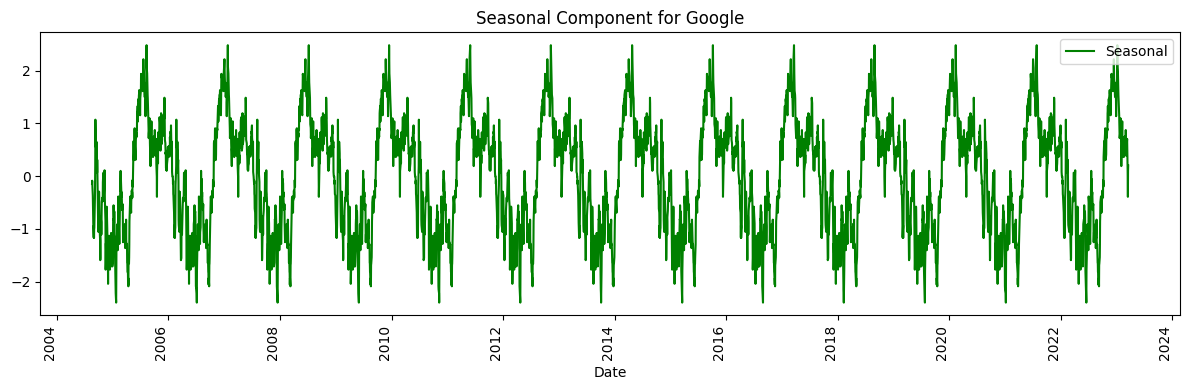

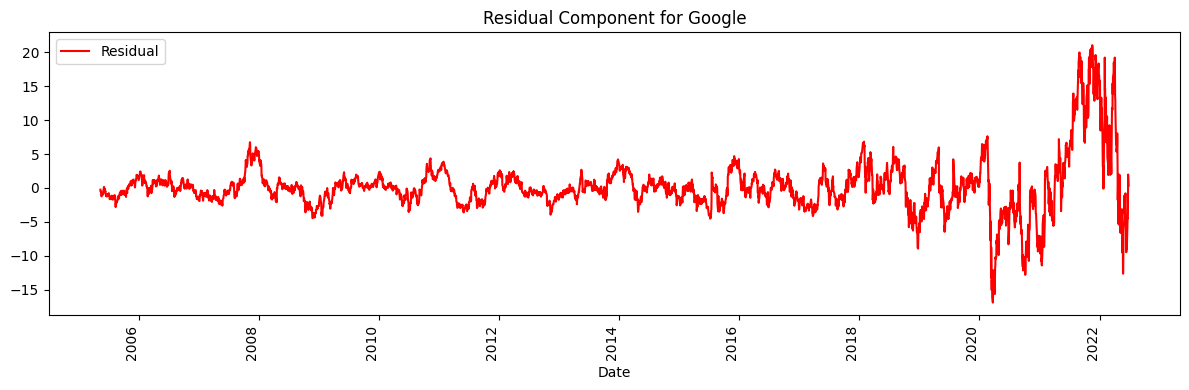

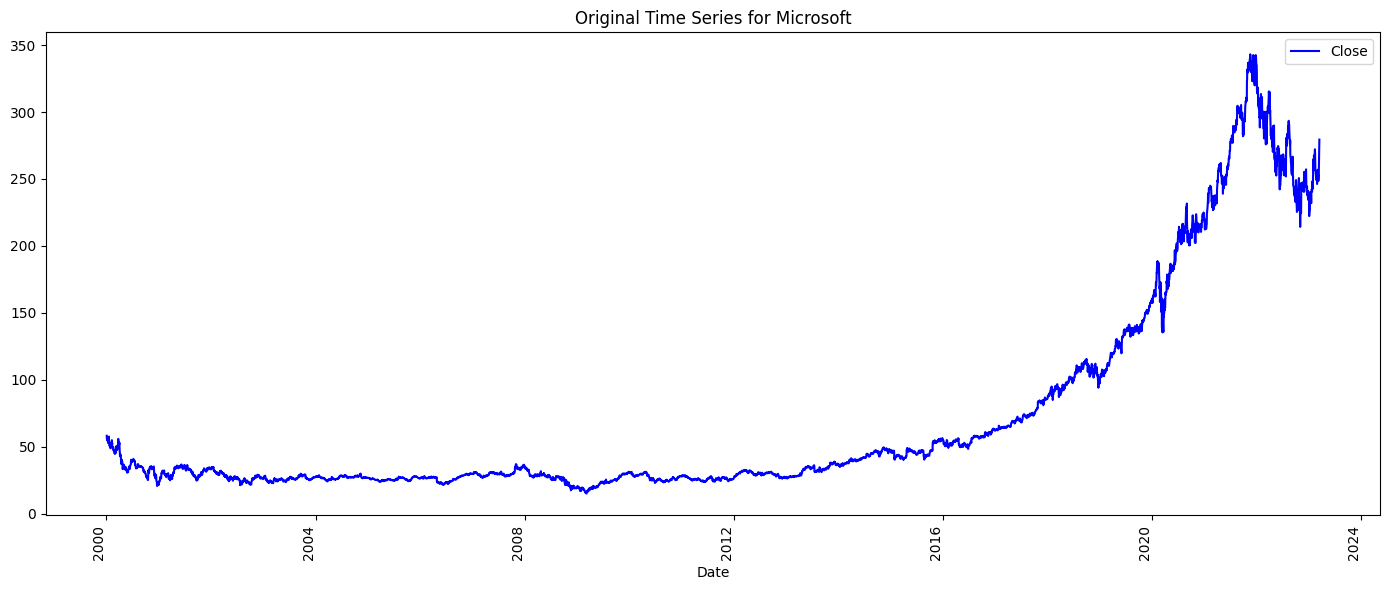

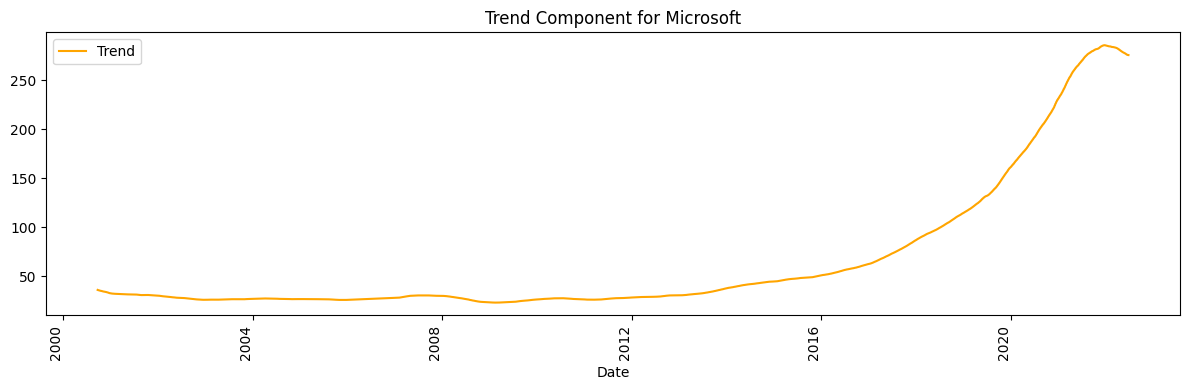

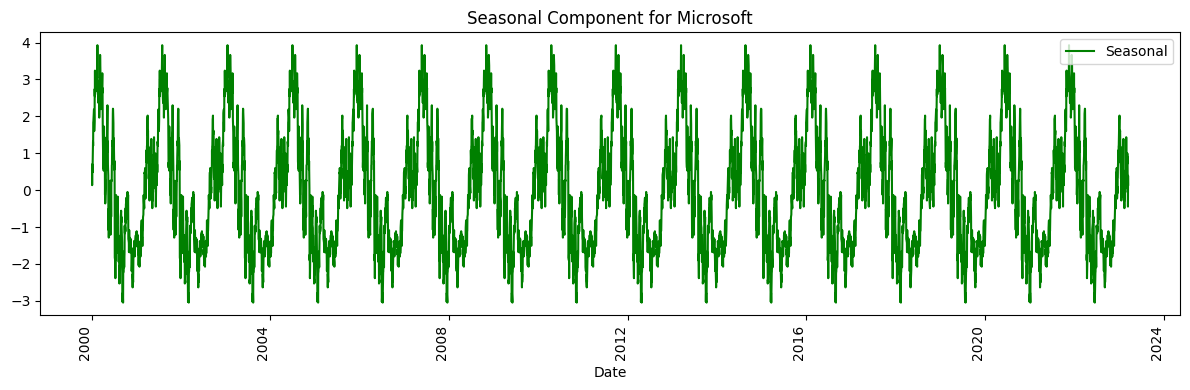

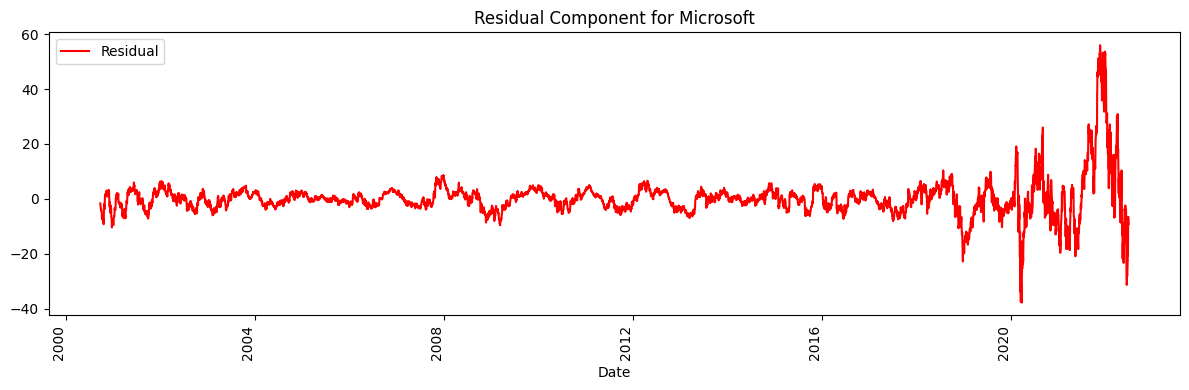

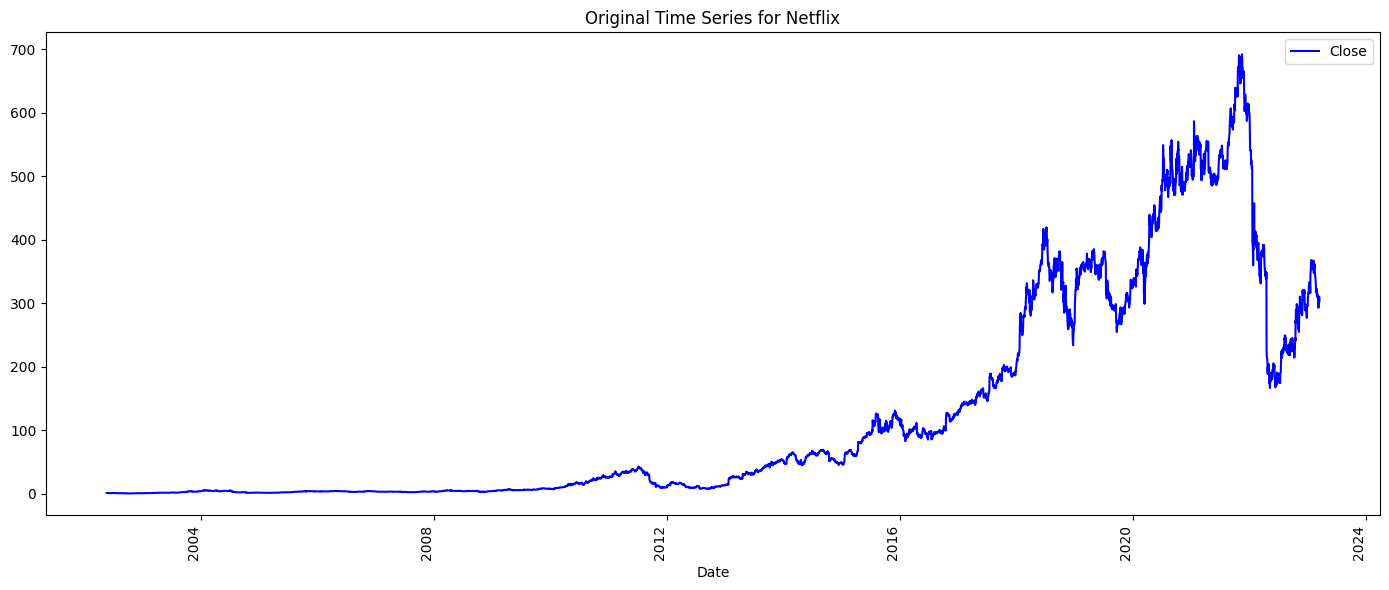

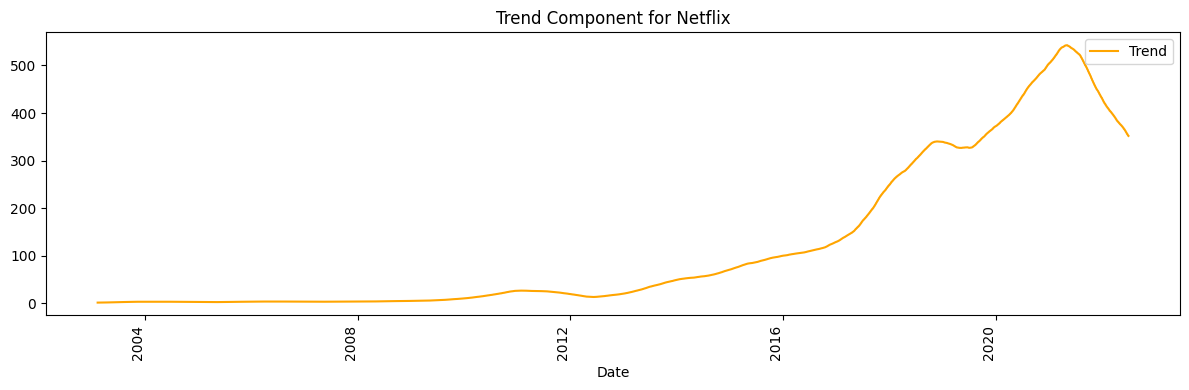

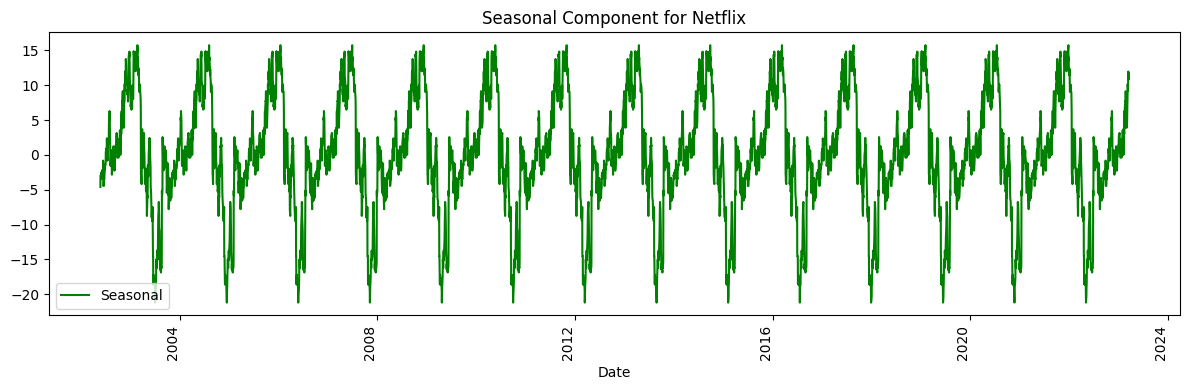

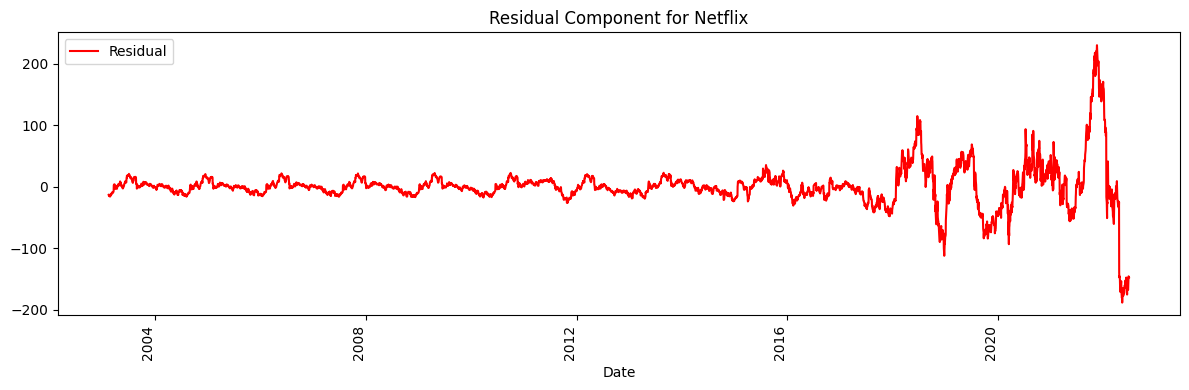

In [16]:
# Group by 'Company'
grouped = df.groupby('Company')

def decompose_and_plot(group, company_name):
    # Decompose the time series
    decomposition = seasonal_decompose(group['Close'].dropna(), model='additive', period=365)  # Adjust the period as needed
    
    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original time series
    plt.figure(figsize=(14, 6))
    group['Close'].plot(title=f'Original Time Series for {company_name}', color='blue')
    plt.xticks(rotation=90)
    plt.legend(['Close'])
    plt.tight_layout()
    plt.show()

    # Plot the trend component
    plt.figure(figsize=(12, 4))
    trend.plot(title=f'Trend Component for {company_name}', color='orange')
    plt.xticks(rotation=90)
    plt.legend(['Trend'])
    plt.tight_layout()
    plt.show()

    # Plot the seasonal component
    plt.figure(figsize=(12, 4))
    seasonal.plot(title=f'Seasonal Component for {company_name}', color='green')
    plt.xticks(rotation=90)
    plt.legend(['Seasonal'])
    plt.tight_layout()
    plt.show()

    # Plot the residual component
    plt.figure(figsize=(12, 4))
    residual.plot(title=f'Residual Component for {company_name}', color='red')
    plt.xticks(rotation=90)
    plt.legend(['Residual'])
    plt.tight_layout()
    plt.show()

# Automatically decompose and plot data for each company
for company_name, group in grouped:
    decompose_and_plot(group, company_name)


# Volume Trends and Price Change Relationships for Each Company

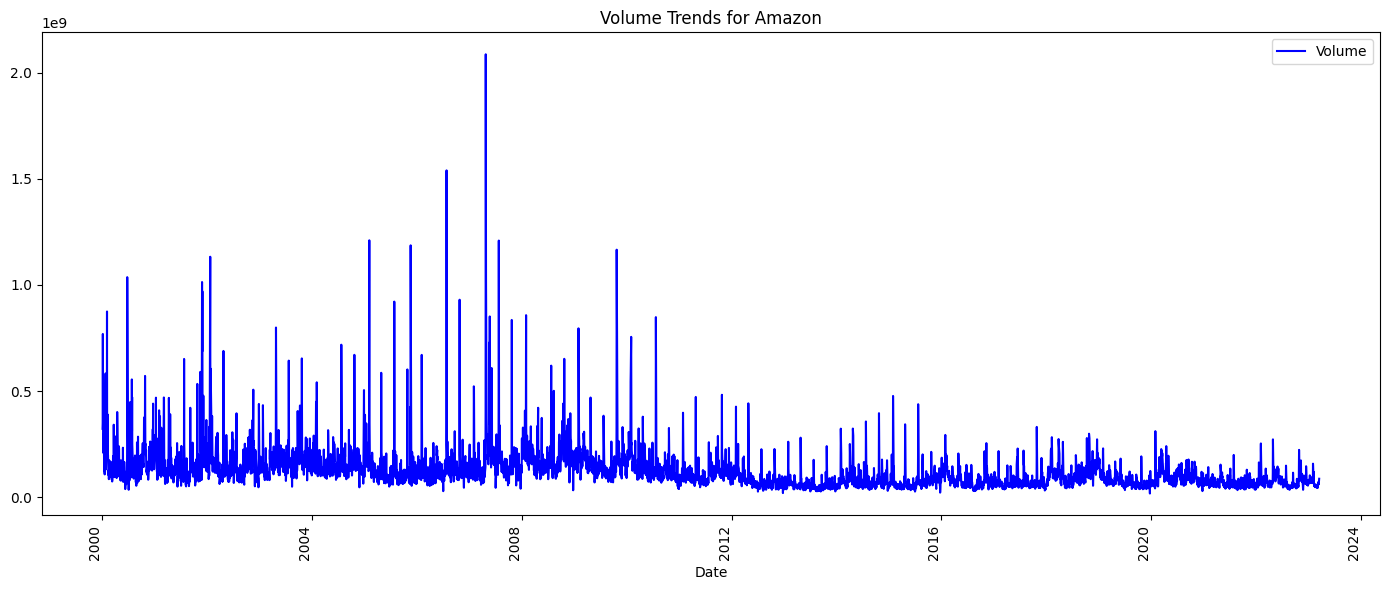

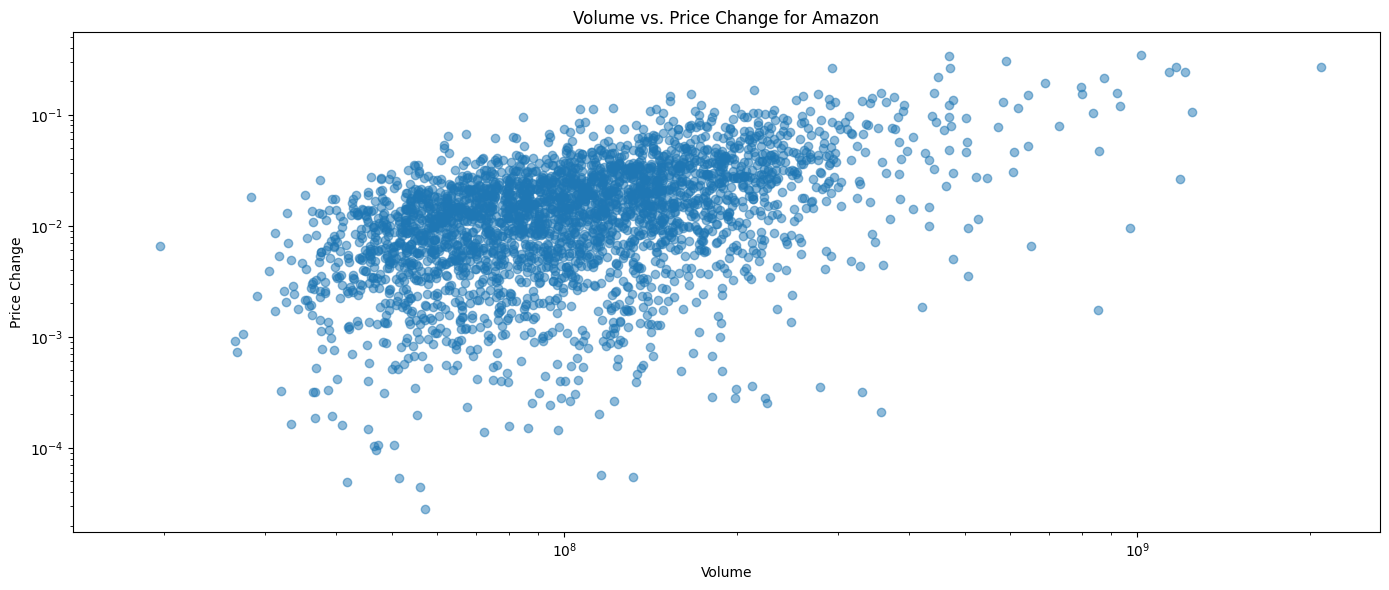

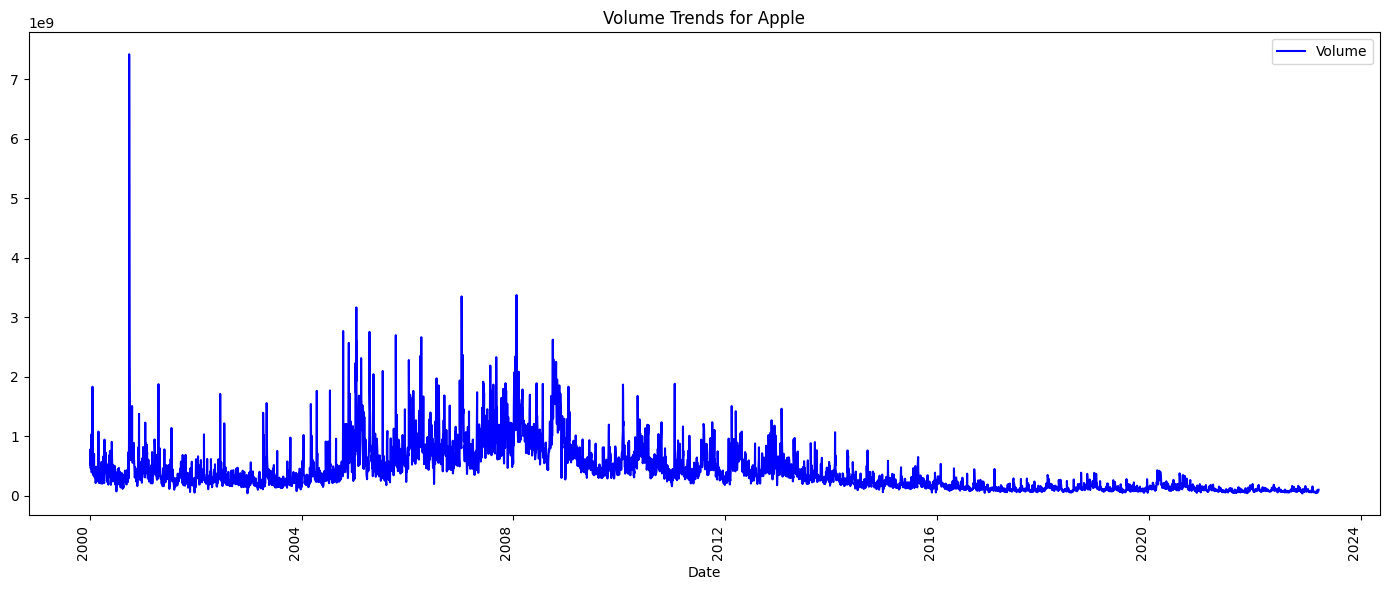

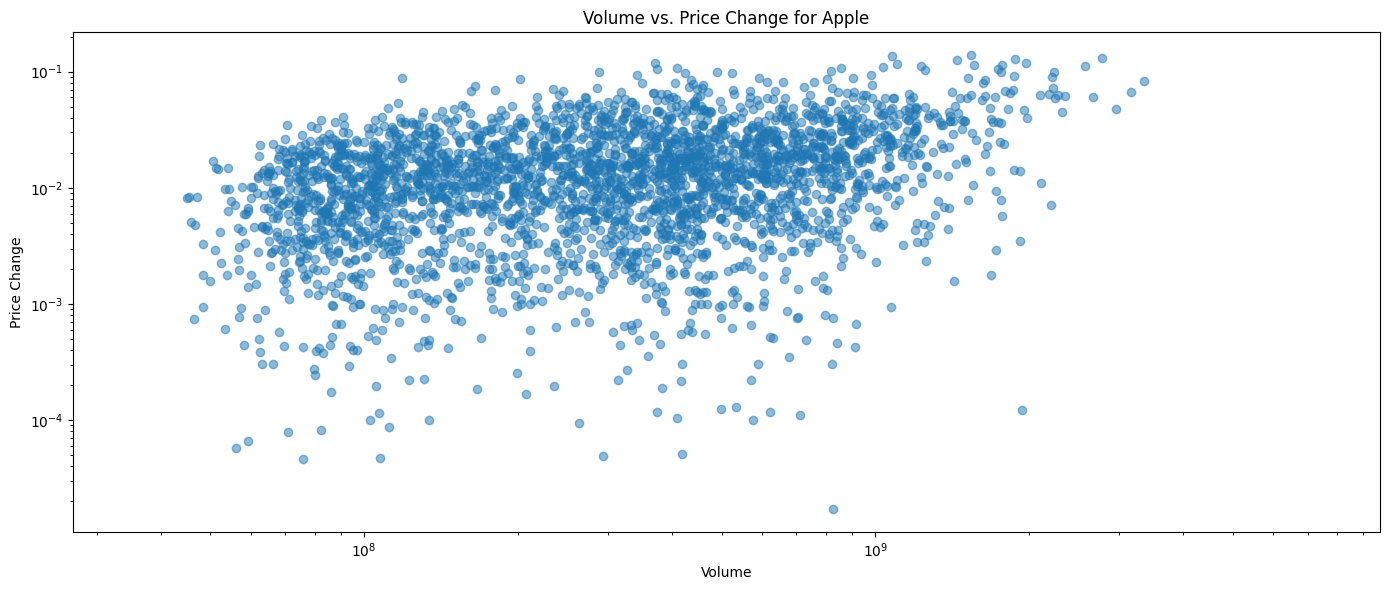

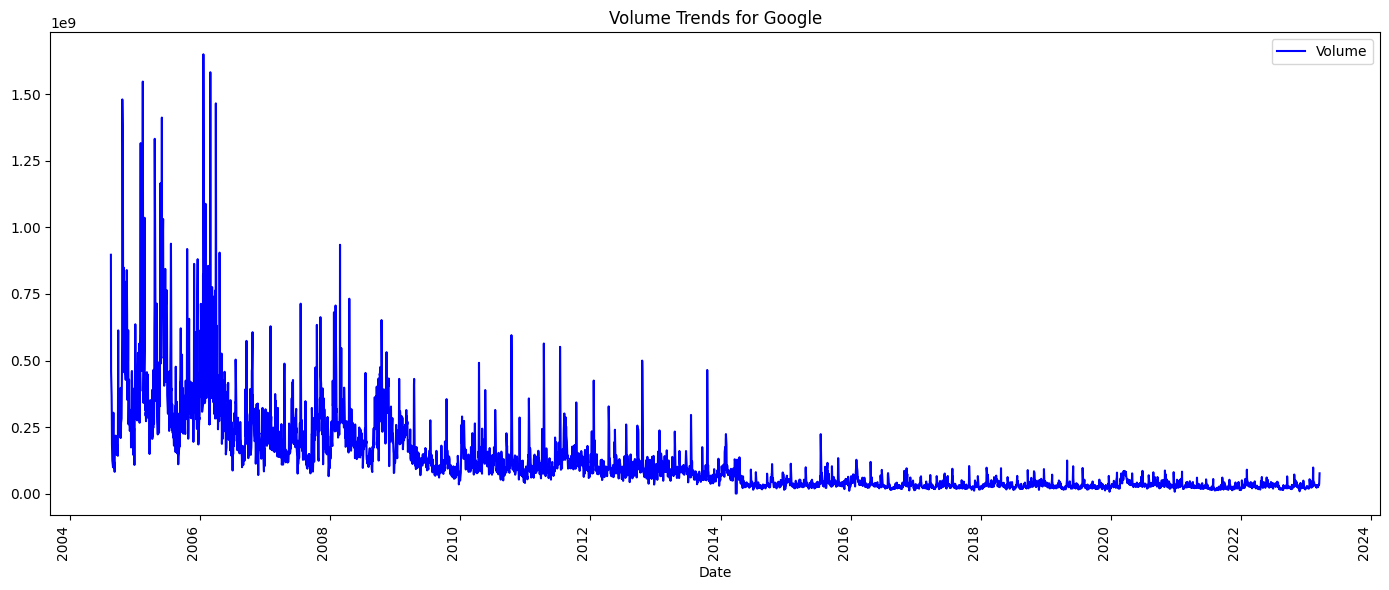

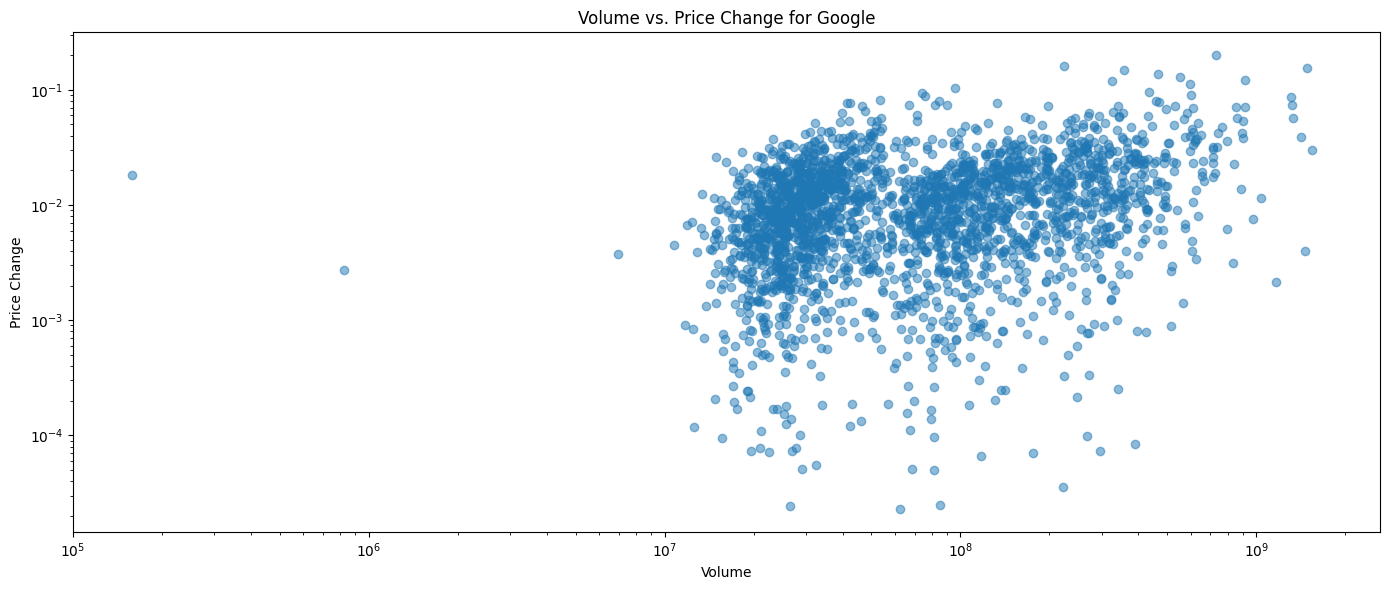

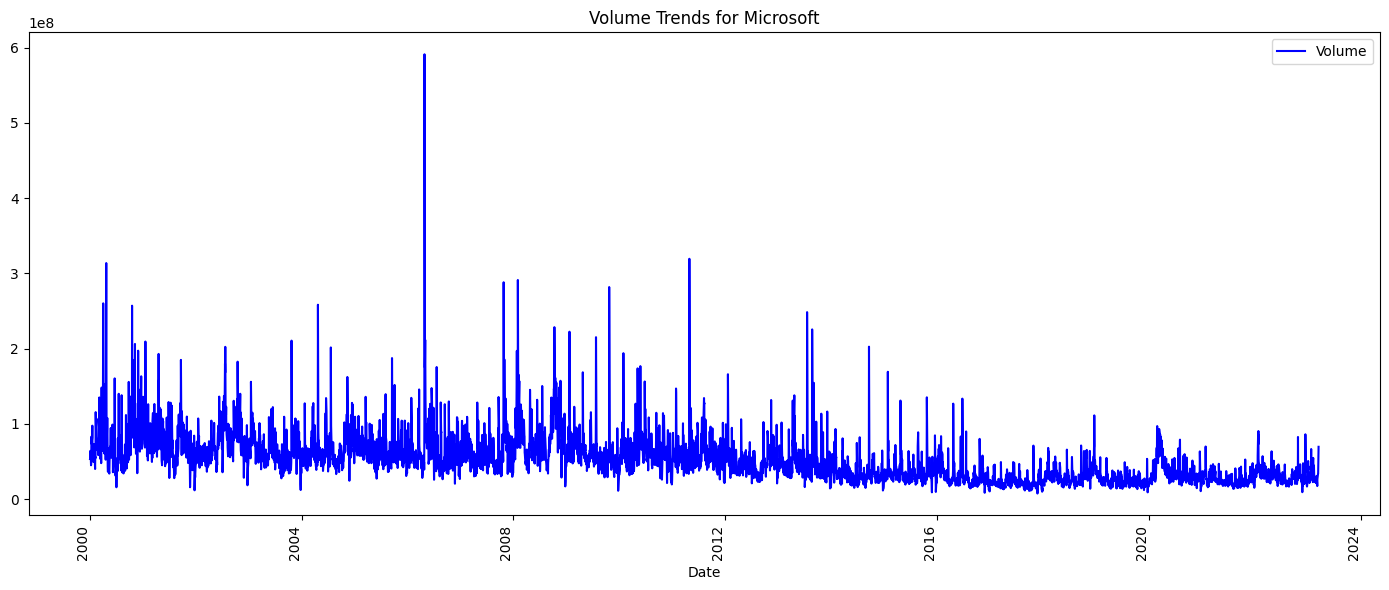

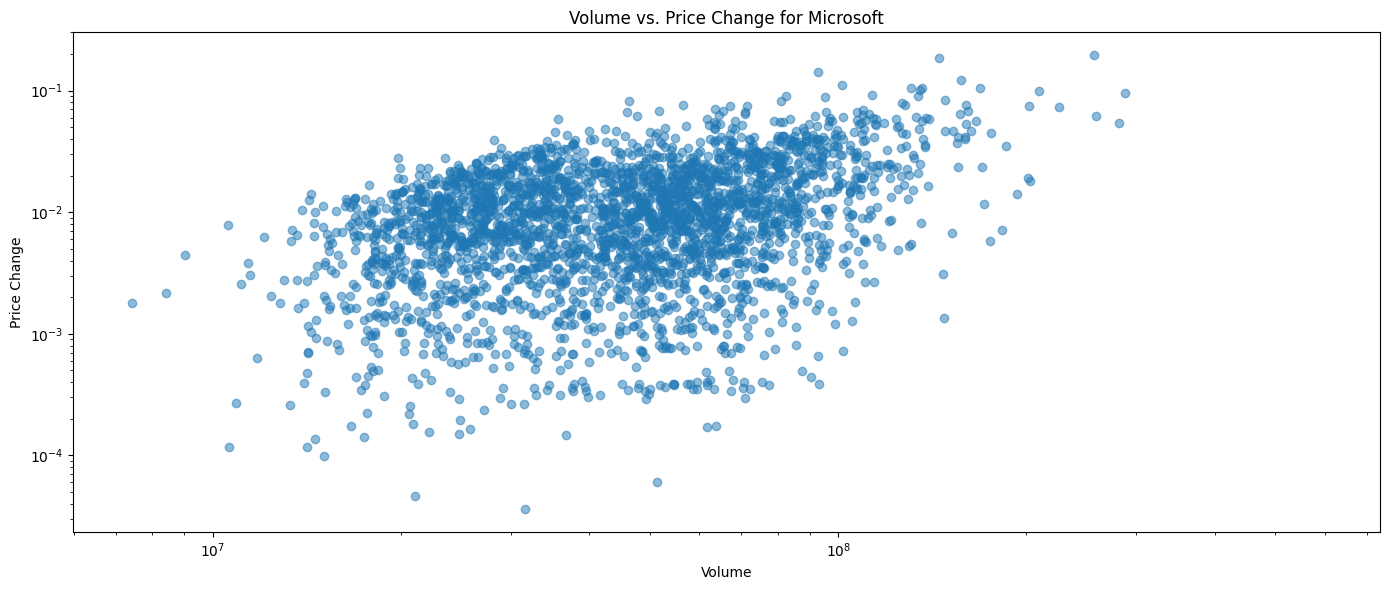

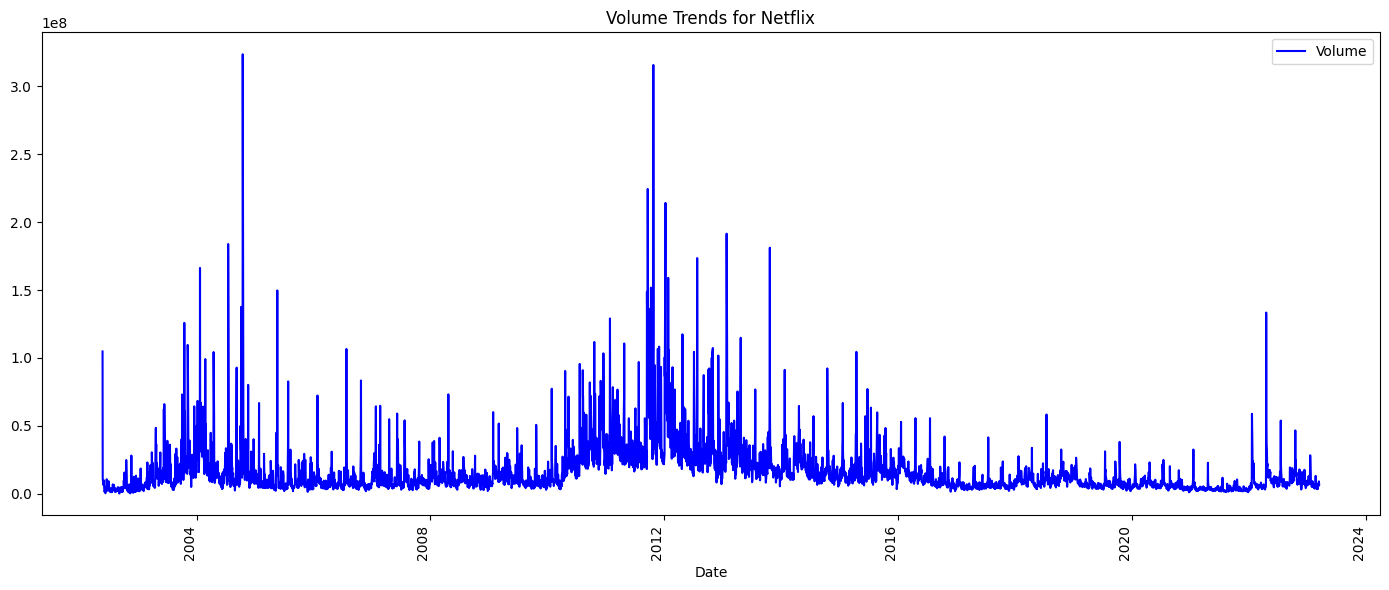

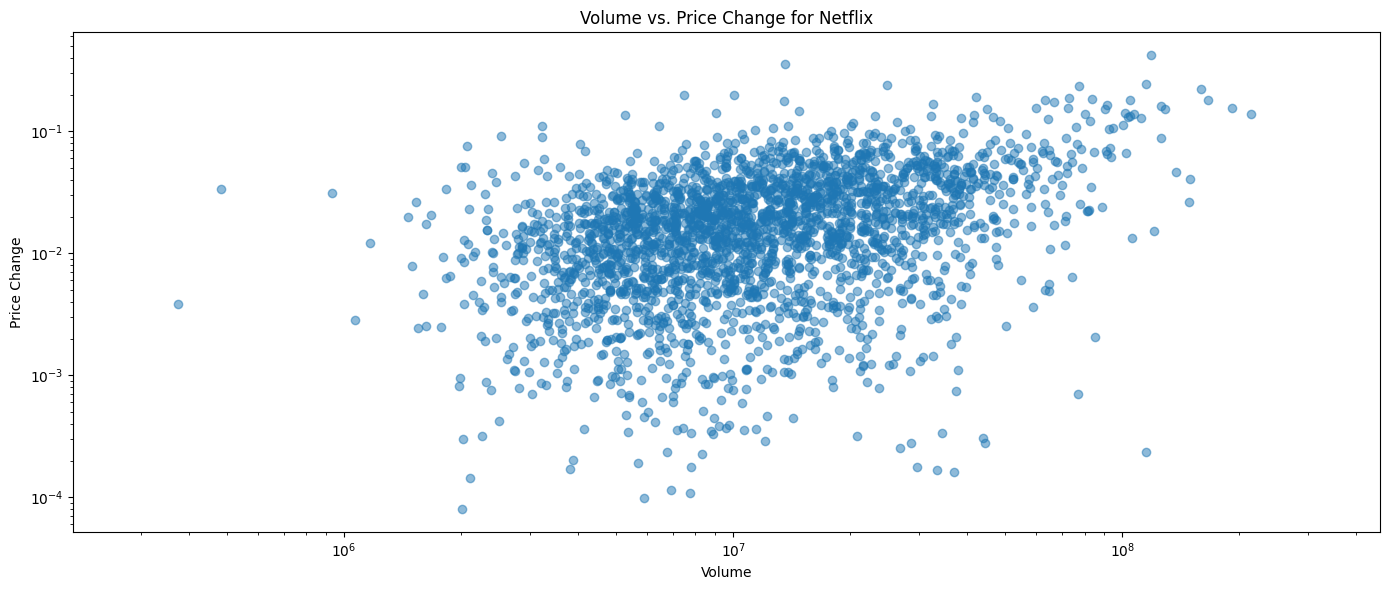

In [17]:
# Group by 'Company'
grouped = df.groupby('Company')

def plot_volume_trends_and_relationships(group, company_name):
    # Plot Volume Trends
    plt.figure(figsize=(14, 6))
    group['Volume'].plot(title=f'Volume Trends for {company_name}', color='blue')
    plt.xticks(rotation=90)
    plt.legend(['Volume'])
    plt.tight_layout()
    plt.show()
    
    # Calculate price change
    group['Price_Change'] = group['Close'].pct_change()

    # Plot Volume vs. Price Change
    plt.figure(figsize=(14, 6))
    plt.scatter(group['Volume'], group['Price_Change'], alpha=0.5)
    plt.title(f'Volume vs. Price Change for {company_name}')
    plt.xlabel('Volume')
    plt.ylabel('Price Change')
    plt.xscale('log')  # Use log scale for better visualization if necessary
    plt.yscale('log')  # Use log scale for better visualization if necessary
    plt.tight_layout()
    plt.show()

# Automatically plot volume trends and relationships for each company
for company_name, group in grouped:
    plot_volume_trends_and_relationships(group, company_name)

# Overall Volume-Price Relationship Across All Data

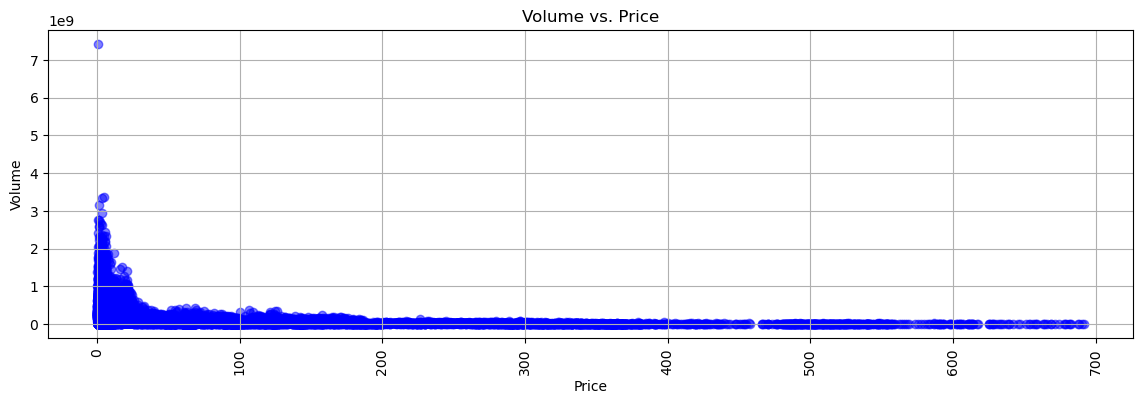

In [59]:
# Volume-Price Relationship
plt.figure(figsize=(14, 4))
plt.scatter(df['Close'], df['Volume'], alpha=0.5, c='blue')
plt.title('Volume vs. Price')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(True)
plt.show()

# Augmented Dickey-Fuller Test Results for Stationarity of Closing Prices

In [23]:
# Perform Augmented Dickey-Fuller Test
result = adfuller(df['Close'].dropna())  

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.0863783744490587
p-value: 0.027577810950538573
Critical Values: {'1%': -3.430588804975054, '5%': -2.861645544973999, '10%': -2.566826178433165}


# Results Interpretation:

ADF Statistic (-3.086) is less negative than the 1% critical value (-3.431) but more negative than the 5% (-2.862) and 10% (-2.567) critical values.

In our case, the p-value (0.028) is less than 0.05, which means there is enough evidence to reject the null hypothesis at the 5% significance level.

Therefore, the time series data is likely stationary.

# GARCH AND EGARCH MODEL 

In [24]:
# Reset index to convert index columns into regular columns
df.reset_index(inplace=True)

print("\nDataFrame after resetting index:")
print(df)



DataFrame after resetting index:
            Date        Open        High         Low       Close   Adj Close  \
0     2000-01-03    4.075000    4.478125    3.952344    4.468750    4.468750   
1     2000-01-04    4.268750    4.575000    4.087500    4.096875    4.096875   
2     2000-01-05    3.525000    3.756250    3.400000    3.487500    3.487500   
3     2000-01-06    3.565625    3.634375    3.200000    3.278125    3.278125   
4     2000-01-07    3.350000    3.525000    3.309375    3.478125    3.478125   
...          ...         ...         ...         ...         ...         ...   
27430 2023-03-13  147.809998  153.139999  147.699997  150.470001  150.470001   
27431 2023-03-14  151.279999  153.399994  150.100006  152.589996  152.589996   
27432 2023-03-15  151.190002  153.250000  149.919998  152.990005  152.990005   
27433 2023-03-16  152.160004  156.460007  151.639999  155.850006  155.850006   
27434 2023-03-17  156.080002  156.740005  154.279999  155.000000  155.000000   

     

In [25]:
# Ensure your data is sorted by date
df= df.sort_values('Date')

In [26]:
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

In [27]:
df.set_index('Date', inplace=True)

In [28]:
# Check for NaN or infinite values
print(df['log_returns'].isna().sum())  # Should be 0
print(np.isinf(df['log_returns']).sum())  # Should be 0


1
0


In [29]:
df = df.dropna(subset=['log_returns'])
print(df['log_returns'].isna().sum())  

0


In [30]:
# Group by company
grouped = df.groupby('Company')

def calculate_log_returns(group):
    """
    Calculate log returns for the given group.
    """
    group['log_returns'] = np.log(group['Close'] / group['Close'].shift(1))
    group = group.dropna()  
    return group

def fit_garch_model(group):
    """
    Fit a GARCH(1,1) model to the log returns of the given group.
    """
    returns = group['log_returns']
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")
    return garch_fit

def fit_egarch_model(group):
    """
    Fit an EGARCH(1,1) model to the log returns of the given group.
    """
    returns = group['log_returns']
    model = arch_model(returns, vol='EGarch', p=1, q=1)
    egarch_fit = model.fit(disp="off")
    return egarch_fit

def forecast_volatility(garch_fit, forecast_horizon=10):
    """
    Forecast volatility using the fitted GARCH model.
    """
    forecast = garch_fit.forecast(horizon=forecast_horizon)
    forecast_variance = forecast.variance[-forecast_horizon:]
    forecast_volatility = np.sqrt(forecast_variance)
    return forecast_volatility

def forecast_volatility_egarch(egarch_fit, forecast_horizon=10):
    """
    Forecast volatility using the fitted EGARCH model.
    """
    forecast = egarch_fit.forecast(horizon=forecast_horizon, method='simulation')
    forecast_variance = forecast.variance[-forecast_horizon:]
    forecast_volatility = np.sqrt(forecast_variance)
    return forecast_volatility

def calculate_var(volatility_forecast, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) based on forecasted volatility.
    """
    z_score = norm.ppf(confidence_level)
    var = -volatility_forecast.mean() * z_score  # VaR at the given confidence level
    return var


In [88]:
for company, group in grouped:
    # Calculate log returns
    group = calculate_log_returns(group)
    
    # Fit GARCH model
    garch_fit = fit_garch_model(group)
    
    # Fit EGARCH model
    egarch_fit = fit_egarch_model(group)
    
    # Print historical volatility
    historical_volatility = np.sqrt(group['log_returns'].var())  # Historical volatility as std deviation of returns
    print(f"Company: {company}")
    print(f"Historical Volatility: {historical_volatility:.4f}")

    # Compare AIC values
    print(f"GARCH AIC: {garch_fit.aic:.4f}")
    print(f"EGARCH AIC: {egarch_fit.aic:.4f}")
    
    # Check residuals for GARCH
    garch_residuals = garch_fit.resid
    garch_lb_test = acorr_ljungbox(garch_residuals, lags=[10], return_df=True)
    
    # Check residuals for EGARCH
    egarch_residuals = egarch_fit.resid
    egarch_lb_test = acorr_ljungbox(egarch_residuals, lags=[10], return_df=True)
    
    print("GARCH Residuals Ljung-Box Test:")
    print(garch_lb_test)
    print("EGARCH Residuals Ljung-Box Test:")
    print(egarch_lb_test)
    
    # Perform ADF test on EGARCH residuals
    adf_test = adfuller(egarch_residuals.dropna())
    print("EGARCH Residuals ADF Statistic:", adf_test[0])
    print("p-value:", adf_test[1])
    print("Critical Values:", adf_test[4])
    
    # Calculate rolling volatility
    group['rolling_volatility'] = group['log_returns'].rolling(window=30).std()
    print(f"Average Rolling Volatility (30-day window): {group['rolling_volatility'].mean():.4f}")
    print(f"Max Rolling Volatility (30-day window): {group['rolling_volatility'].max():.4f}")
    print(f"Min Rolling Volatility (30-day window): {group['rolling_volatility'].min():.4f}\n")
    
    # Calculate volatility clustering
    volatility_corr = group['rolling_volatility'].autocorr(lag=1)
    print(f"Autocorrelation of Rolling Volatility (Lag 1): {volatility_corr:.4f}\n")
    
    # Forecast volatility using GARCH model
    forecast_garch = forecast_volatility(garch_fit, forecast_horizon=len(group))
    forecast_garch = forecast_garch.values.flatten()  
    actual_volatility = group['rolling_volatility'].dropna().values
    
    # Align lengths of forecasts and actual volatility
    min_length = min(len(forecast_garch), len(actual_volatility))
    forecast_garch = forecast_garch[:min_length]
    actual_volatility = actual_volatility[-min_length:]

    # Calculate RMSE and MAE
    rmse_garch = np.sqrt(mean_squared_error(actual_volatility, forecast_garch))
    mae_garch = mean_absolute_error(actual_volatility, forecast_garch)
    
    print(f"GARCH Model RMSE: {rmse_garch:.4f}")
    print(f"GARCH Model MAE: {mae_garch:.4f}")
    
    # Forecast volatility using EGARCH model
    forecast_egarch = forecast_volatility_egarch(egarch_fit)
    forecast_egarch = forecast_egarch.values.flatten()  
    var_egarch = calculate_var(forecast_egarch)
    print(f"Value at Risk (VaR) for EGARCH model for the next 10 days:\n{var_egarch:.4f}\n")


Company: Amazon
Historical Volatility: 0.0313
GARCH AIC: -25797.5475
EGARCH AIC: -26006.7231
GARCH Residuals Ljung-Box Test:
      lb_stat  lb_pvalue
10  18.559657   0.046226
EGARCH Residuals Ljung-Box Test:
      lb_stat  lb_pvalue
10  18.559657   0.046226
EGARCH Residuals ADF Statistic: -12.865964123983579
p-value: 4.994616370387783e-24
Critical Values: {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
Average Rolling Volatility (30-day window): 0.0269
Max Rolling Volatility (30-day window): 0.0990
Min Rolling Volatility (30-day window): 0.0051

Autocorrelation of Rolling Volatility (Lag 1): 0.9923

GARCH Model RMSE: 0.0168
GARCH Model MAE: 0.0135
Value at Risk (VaR) for EGARCH model for the next 10 days:
-0.0449

Company: Apple
Historical Volatility: 0.0258
GARCH AIC: -28155.4922
EGARCH AIC: -28218.7328
GARCH Residuals Ljung-Box Test:
      lb_stat  lb_pvalue
10  35.717762   0.000094
EGARCH Residuals Ljung-Box Test:
      lb_stat  lb_pvalue
10  35.71

# Result Interpretation
Volatility Analysis Insights
Model Performance:

EGARCH Models generally provide better fit (lower AIC) and handle volatility clustering more effectively than GARCH Models across all companies.
Historical Volatility:

Model Accuracy:

GARCH models generally have lower RMSE and MAE compared to EGARCH for most companies, indicating they perform better in fitting historical data for volatility.
Residuals Testing:

EGARCH models generally have better residuals characteristics with lower Ljung-Box test p-values, indicating a better fit compared to GARCH models.

# Volatility Forecasting and Analysis: GARCH and EGARCH Models for Each Company

In [33]:
for company, group in grouped:
    # Calculate log returns
    group = calculate_log_returns(group)

    # Fit GARCH and EGARCH models
    garch_fit = fit_garch_model(group)
    egarch_fit = fit_egarch_model(group)
    
    # Forecast volatility using GARCH model
    forecast_garch = forecast_volatility(garch_fit)
    var_garch = calculate_var(forecast_garch.values.flatten())
    
    # Forecast volatility using EGARCH model
    forecast_egarch = forecast_volatility_egarch(egarch_fit)
    var_egarch = calculate_var(forecast_egarch.values.flatten())
    
    # Print predicted volatilities
    print(f"{company} - Predicted Volatility (GARCH) for the next 10 days: {forecast_garch.values.flatten()}")
    print(f"{company} - Predicted Volatility (EGARCH) for the next 10 days: {forecast_egarch.values.flatten()}")
    
    # Perform ADF test on EGARCH residuals
    adf_test = adfuller(egarch_fit.resid.dropna())
    print(f"{company} - EGARCH Residuals ADF Statistic:", adf_test[0])
    print(f"{company} - p-value:", adf_test[1])
    print(f"{company} - Critical Values:", adf_test[4])
    
    # Calculate rolling volatility
    group['rolling_volatility'] = group['log_returns'].rolling(window=30).std()
    print(f"{company} - Average Rolling Volatility (30-day window): {group['rolling_volatility'].mean():.4f}")
    print(f"{company} - Max Rolling Volatility (30-day window): {group['rolling_volatility'].max():.4f}")
    print(f"{company} - Min Rolling Volatility (30-day window): {group['rolling_volatility'].min():.4f}\n")
    
    # Calculate volatility clustering
    volatility_corr = group['rolling_volatility'].autocorr(lag=1)
    print(f"{company} - Autocorrelation of Rolling Volatility (Lag 1): {volatility_corr:.4f}\n")
    
    # Print VaR for GARCH and EGARCH models
    print(f"{company} - Value at Risk (VaR) for GARCH model for the next 10 days: {var_garch:.4f}")
    print(f"{company} - Value at Risk (VaR) for EGARCH model for the next 10 days: {var_egarch:.4f}\n")



Amazon - Predicted Volatility (GARCH) for the next 10 days: [0.02289609 0.02309475 0.02328779 0.02347543 0.02365787 0.02383531
 0.02400793 0.02417589 0.02433938 0.02449854]
Amazon - Predicted Volatility (EGARCH) for the next 10 days: [0.02679632 0.02688051 0.02705614 0.02718632 0.02727651 0.02738311
 0.02752209 0.0276509  0.02780819 0.02787601]
Amazon - EGARCH Residuals ADF Statistic: -12.865964123983579
Amazon - p-value: 4.994616370387783e-24
Amazon - Critical Values: {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
Amazon - Average Rolling Volatility (30-day window): 0.0269
Amazon - Max Rolling Volatility (30-day window): 0.0990
Amazon - Min Rolling Volatility (30-day window): 0.0051

Amazon - Autocorrelation of Rolling Volatility (Lag 1): 0.9923

Amazon - Value at Risk (VaR) for GARCH model for the next 10 days: -0.0390
Amazon - Value at Risk (VaR) for EGARCH model for the next 10 days: -0.0450

Apple - Predicted Volatility (GARCH) for the next 10 d

# Result Interpretation

1.Volatility Trends:

Amazon and Netflix exhibit higher predicted volatilities compared to Apple, Microsoft, and Google.

EGARCH models generally predict higher volatilities compared to GARCH models for all companies.

2.Value at Risk (VaR):

Netflix has the highest negative VaR, indicating the greatest potential for loss.

Amazon and Google also have relatively high negative VaR, suggesting significant risk in these stocks.

3.Model Performance:

EGARCH models provide higher volatility estimates and greater VaR, reflecting their sensitivity to volatility clustering and leverage effects.

GARCH models show more stable volatility predictions over the next 10 days compared to EGARCH.

4.Volatility Extremes:

The average rolling volatility is highest for Netflix, highlighting its greater historical volatility compared to other stocks.

Apple and Microsoft have lower rolling volatilities, suggesting more stable price movements.

5.Autocorrelation:

High autocorrelation of rolling volatility (near 1) across all stocks indicates strong persistence in volatility, especially notable in Amazon and Microsoft.

# Residuals and ACF Analysis for GARCH Model by Company

Residual Analysis for Amazon:


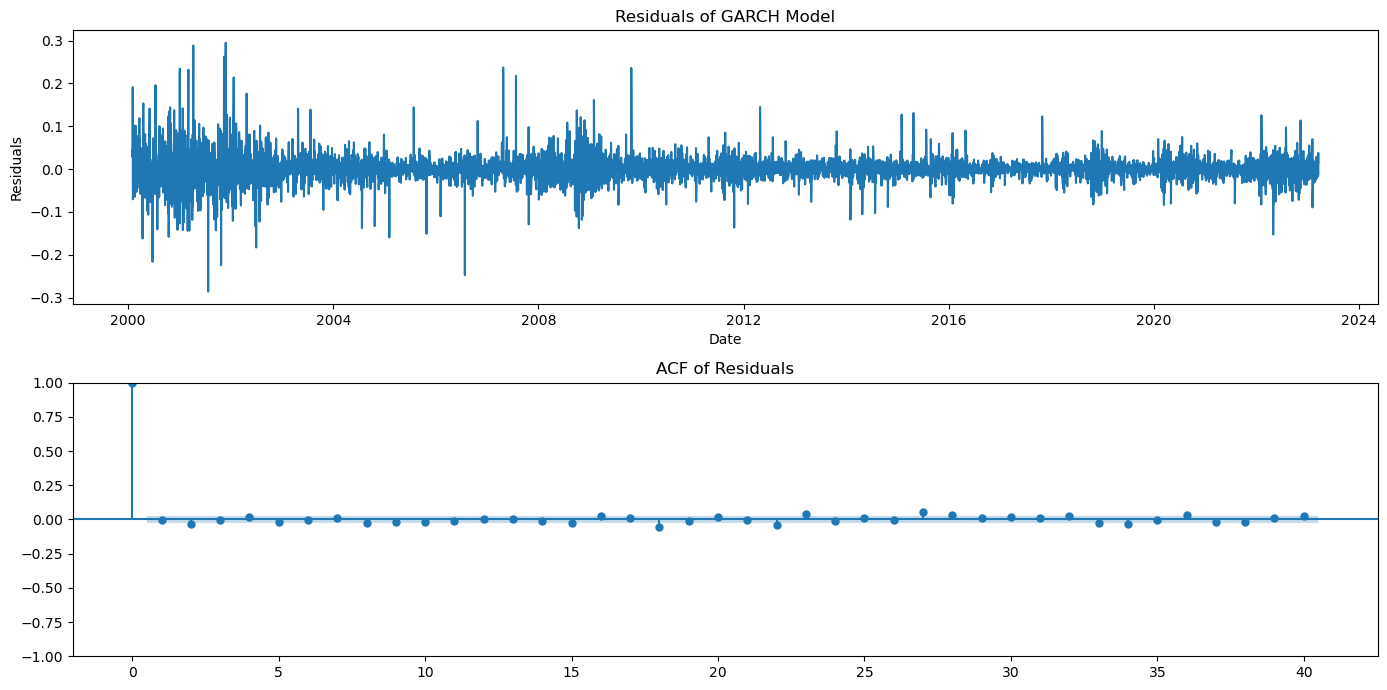

Residual Analysis for Apple:


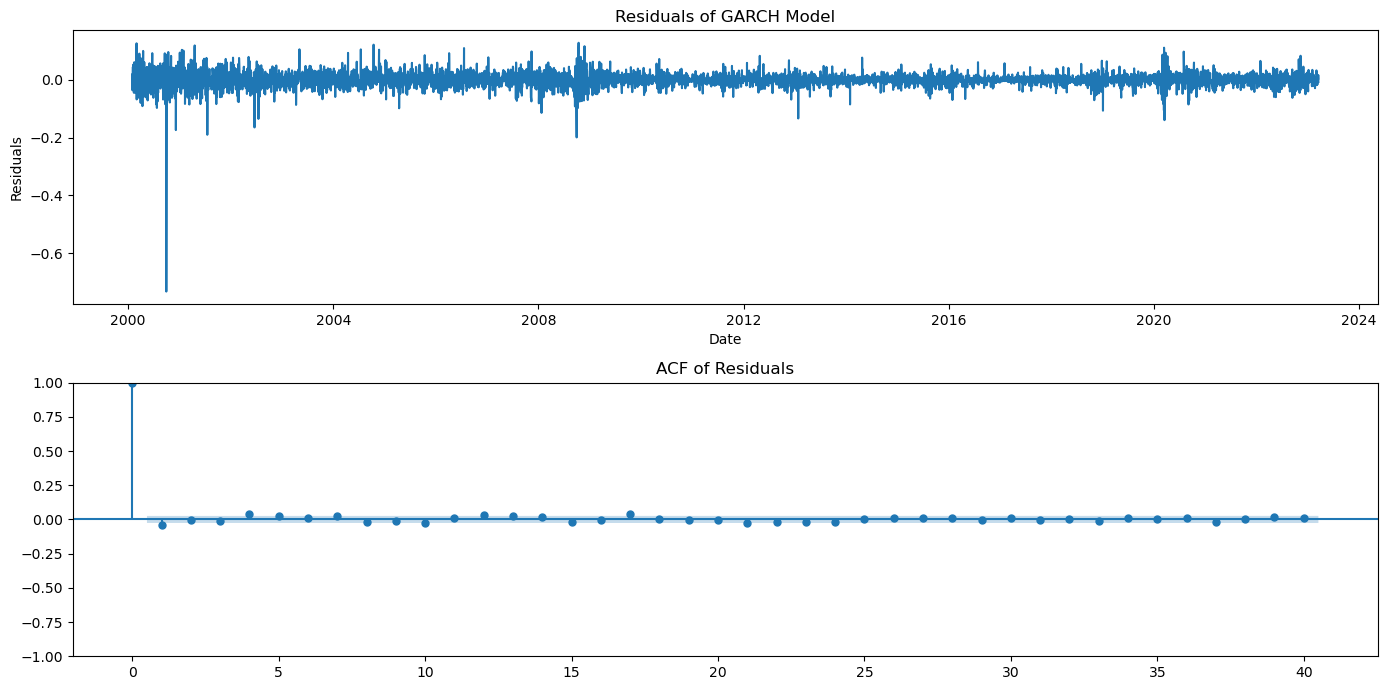

Residual Analysis for Google:


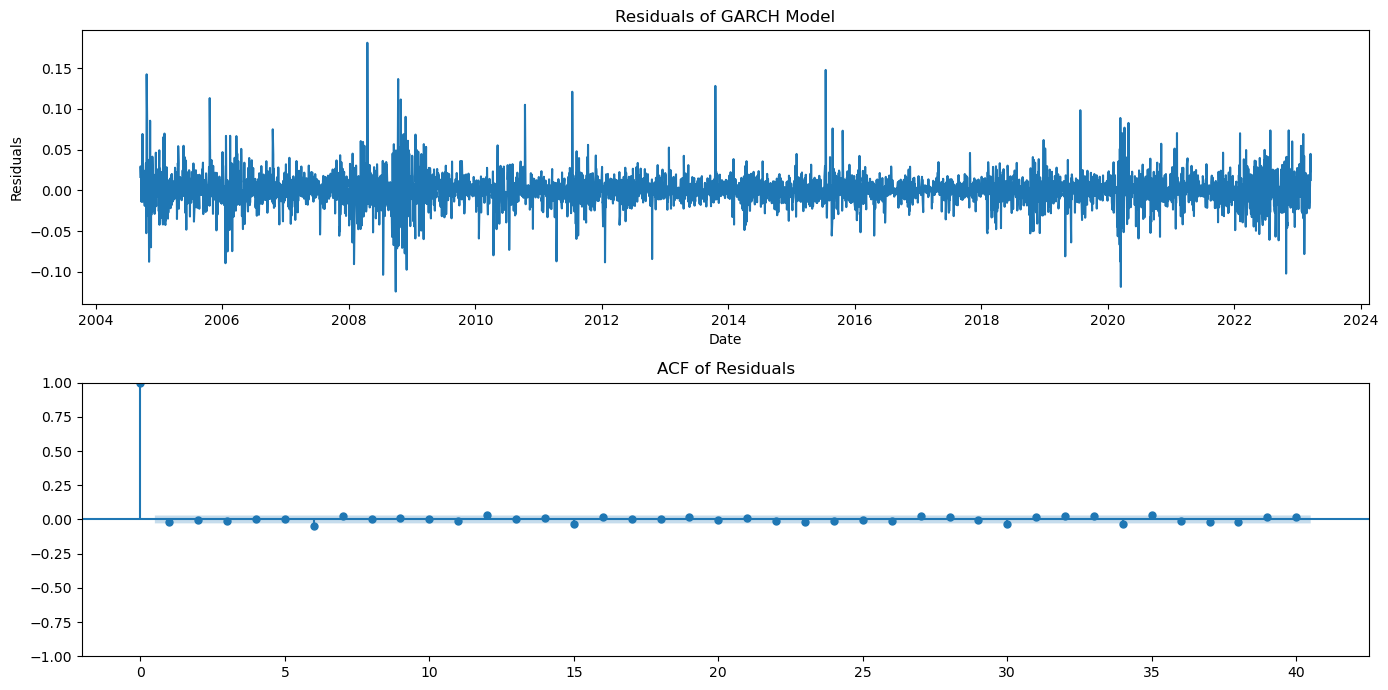

Residual Analysis for Microsoft:


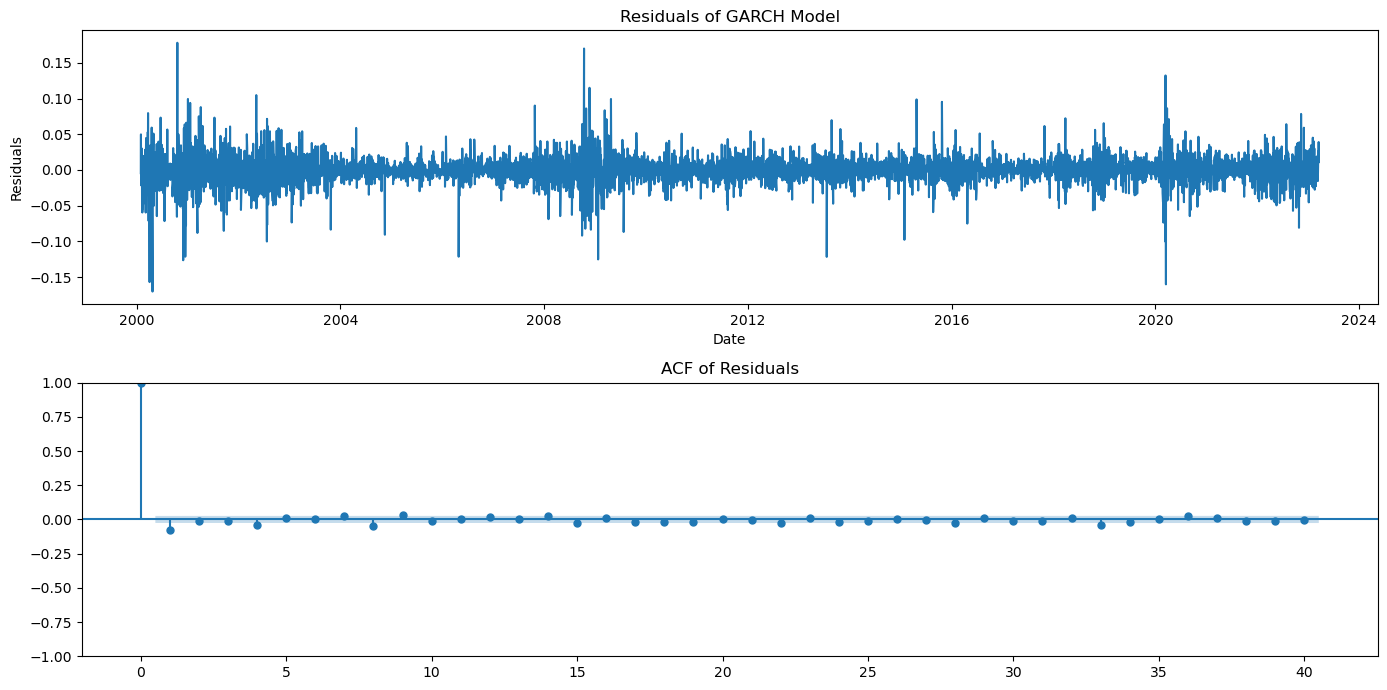

Residual Analysis for Netflix:


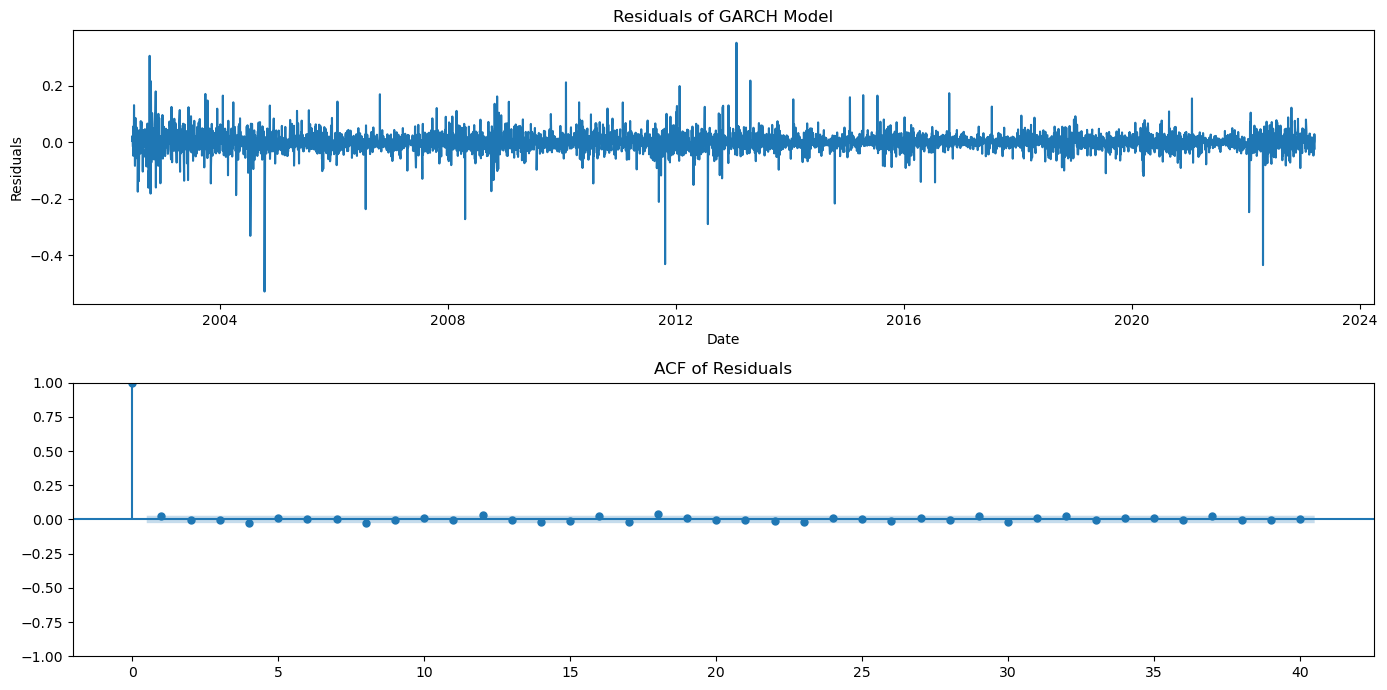

In [34]:
def plot_residuals_analysis_garch(garch_fit):
    """
    Plot residuals and ACF of residuals.
    """
    garch_residuals = garch_fit.resid
    
    plt.figure(figsize=(14, 7))

    # Plot residuals
    plt.subplot(2, 1, 1)
    plt.plot(garch_residuals)
    plt.title('Residuals of GARCH Model')
    plt.xlabel('Date')
    plt.ylabel('Residuals')

    # Plot ACF of residuals
    plt.subplot(2, 1, 2)
    plot_acf(garch_residuals, ax=plt.gca(), lags=40)
    plt.title('ACF of Residuals')
    
    plt.tight_layout()
    plt.show()

for company, group in grouped:
    group = calculate_log_returns(group)
    garch_fit = fit_garch_model(group)
    
    print(f"Residual Analysis for {company}:")
    plot_residuals_analysis_garch(garch_fit)


# Residuals and ACF Analysis for eGARCH Model by Company

Residual Analysis for Amazon:


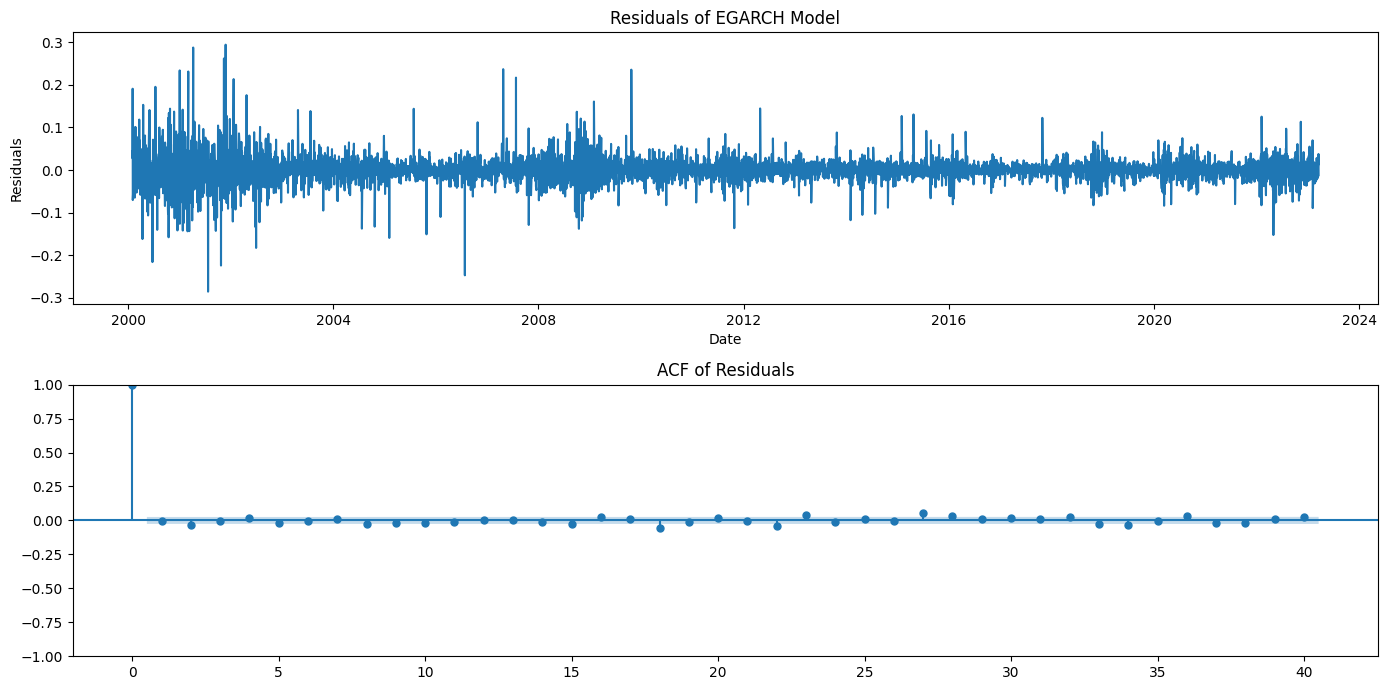

Residual Analysis for Apple:


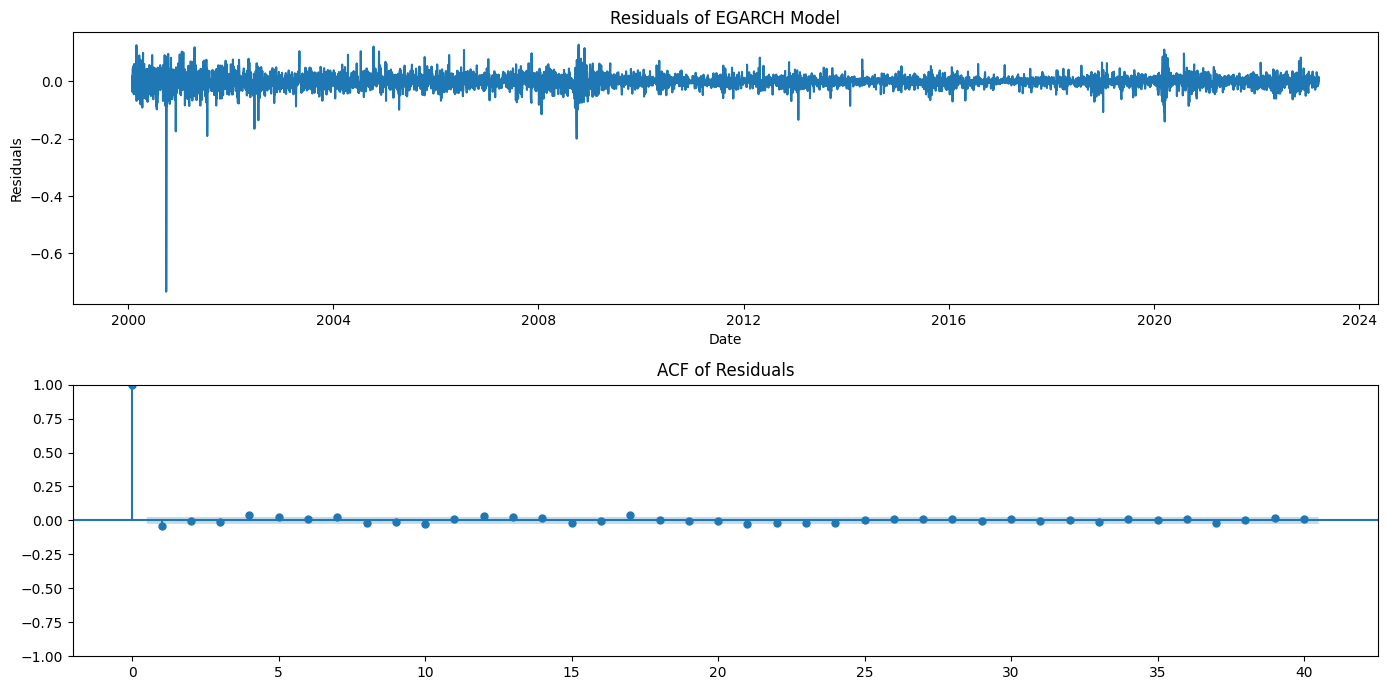

Residual Analysis for Google:


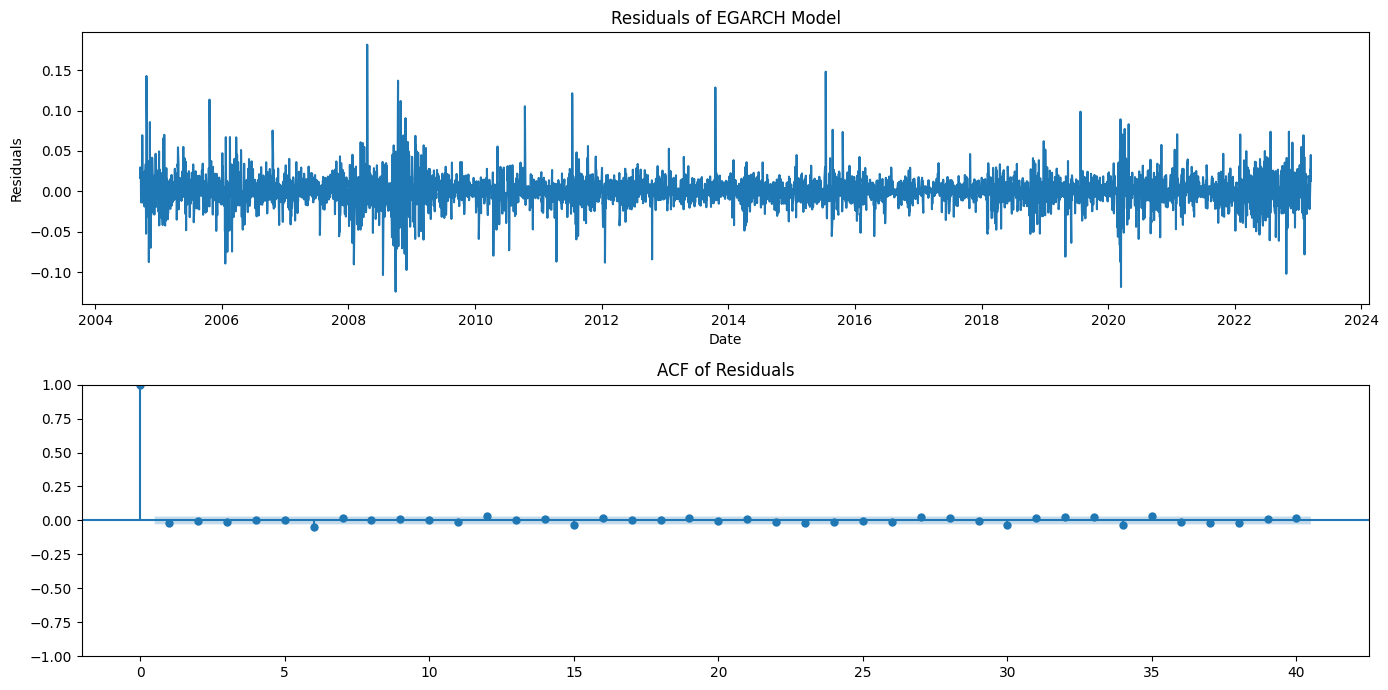

Residual Analysis for Microsoft:


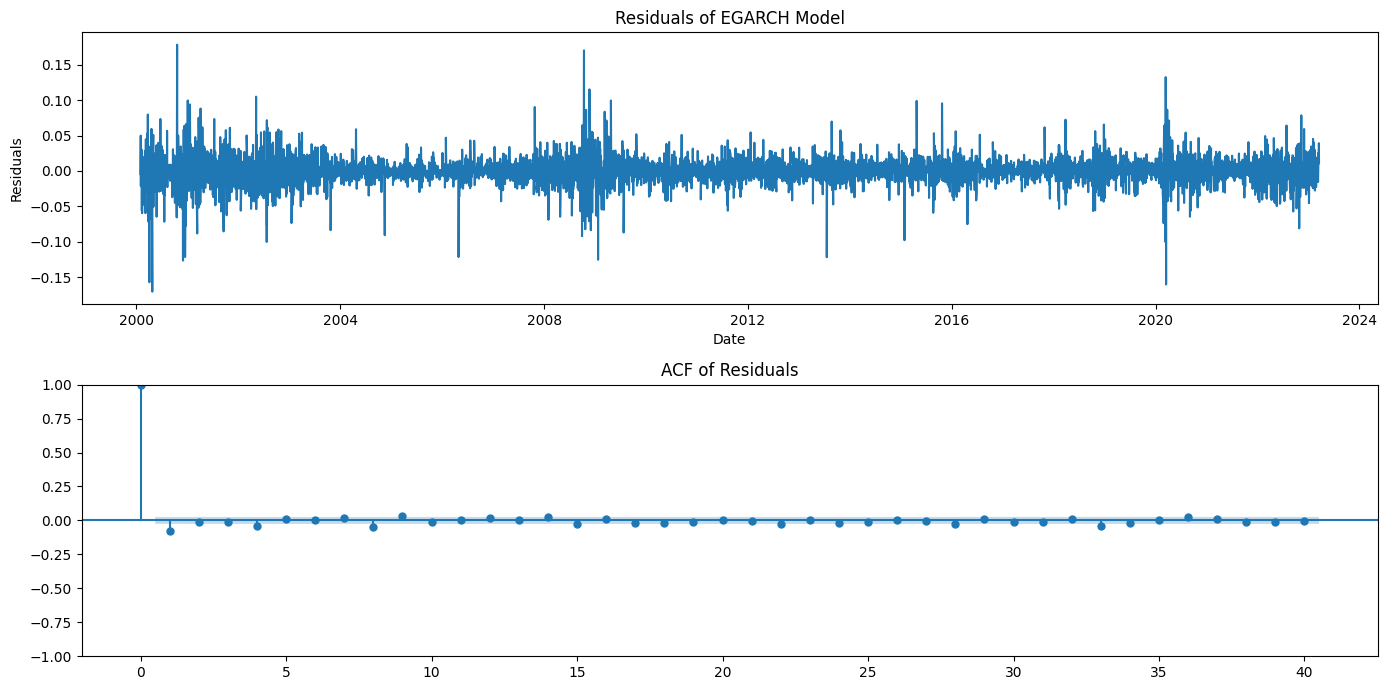

Residual Analysis for Netflix:


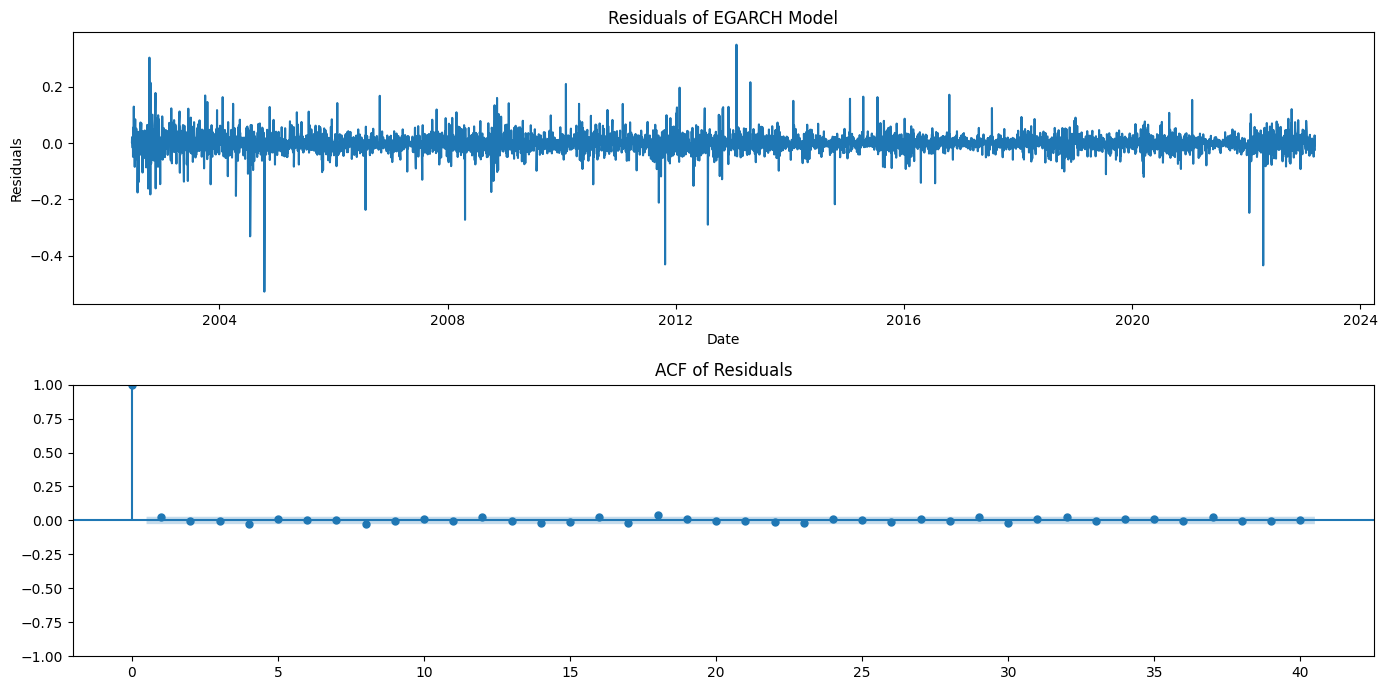

In [59]:
def plot_residuals_analysis_egarch(egarch_fit):
    """
    Plot residuals and ACF of residuals.
    """
    egarch_residuals = egarch_fit.resid
    
    plt.figure(figsize=(14, 7))

    # Plot residuals
    plt.subplot(2, 1, 1)
    plt.plot(egarch_residuals)
    plt.title('Residuals of EGARCH Model')
    plt.xlabel('Date')
    plt.ylabel('Residuals')

    # Plot ACF of residuals
    plt.subplot(2, 1, 2)
    plot_acf(egarch_residuals, ax=plt.gca(), lags=40)
    plt.title('ACF of Residuals')
    
    plt.tight_layout()
    plt.show()

for company, group in grouped:
    group = calculate_log_returns(group)
    egarch_fit = fit_egarch_model(group)
    
    print(f"Residual Analysis for {company}:")
    plot_residuals_analysis_egarch(egarch_fit)


# Investment Allocation Based on Value at Risk (VaR) for Each Company

In [34]:
# VaR values for companies
var_values = {
    'Amazon': 0.038696,
    'Apple': 0.028977,
    'Google': 0.036573,
    'Microsoft': 0.03227,
    'Netflix': 0.054433
}

# Convert VaR values to DataFrame
var_df = pd.DataFrame(list(var_values.items()), columns=['Company', 'VaR'])
var_df['Inverse_VaR'] = 1 / var_df['VaR']
var_df['Weight'] = var_df['Inverse_VaR'] / var_df['Inverse_VaR'].sum()

# Total investment
total_investment = 10000

# Allocate investment based on weights
var_df['Investment'] = var_df['Weight'] * total_investment

print(var_df)


     Company       VaR  Inverse_VaR    Weight   Investment
0     Amazon  0.038696    25.842464  0.188556  1885.555515
1      Apple  0.028977    34.510129  0.251798  2517.978265
2     Google  0.036573    27.342575  0.199501  1995.008782
3  Microsoft  0.032270    30.988534  0.226103  2261.030561
4    Netflix  0.054433    18.371209  0.134043  1340.426877


# Result Interpretation
Amazon: With a VaR of 0.038696, Amazon has an Inverse_VaR of 25.842464. The weight of Amazon in the investment portfolio is 0.188556, meaning approximately 18.86% of the total investment is allocated to Amazon. This amounts to $1885.56.

Apple: With a VaR of 0.028977, Apple has a higher Inverse_VaR of 34.510129. The weight is 0.251798, meaning approximately 25.18% of the total investment is allocated to Apple. This amounts to $2517.98.

Google: Google has a VaR of 0.036573, resulting in an Inverse_VaR of 27.342575. The weight is 0.199501, meaning approximately 19.95% of the total investment is allocated to Google. This amounts to $1995.01.

Microsoft: With a VaR of 0.032270, Microsoft’s Inverse_VaR is 30.988534. The weight is 0.226103, meaning approximately 22.61% of the total investment is allocated to Microsoft. This amounts to $2261.03.

Netflix: Netflix has the highest VaR of 0.054433, resulting in the lowest Inverse_VaR of 18.371209. The weight is 0.134043, meaning approximately 13.40% of the total investment is allocated to Netflix. This amounts to $1340.43.

# Mean-Variance Optimization

# Optimal Portfolio Allocation Based on Mean Returns and Covariance Matrix

In [35]:
# Pivot DataFrame to get log returns in columns
returns_pivot = df.pivot(columns='Company', values='log_returns')

# Drop rows with NaN values
returns_pivot = returns_pivot.dropna()

# Check data shape
print("Cleaned Returns DataFrame:\n", returns_pivot.head())
print("Number of data points:", len(returns_pivot))
print("Data Types:\n", returns_pivot.dtypes)

# Calculate mean returns and covariance matrix
mean_returns = returns_pivot.mean()
cov_matrix = returns_pivot.cov()

# Print calculated statistics
print("Mean Returns:\n", mean_returns)
print("Covariance Matrix:\n", cov_matrix)

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    returns, risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(returns - risk_free_rate) / risk

def check_sum(weights):
    return np.sum(weights) - 1

# Number of assets
num_assets = len(mean_returns)
initial_weights = num_assets * [1. / num_assets]
bounds = tuple((0, 1) for asset in range(num_assets))
constraints = ({'type': 'eq', 'fun': check_sum})

# Optimize
optimized_results = sco.minimize(negative_sharpe_ratio, initial_weights, 
                                 args=(mean_returns, cov_matrix), 
                                 method='SLSQP', 
                                 bounds=bounds, 
                                 constraints=constraints)

# Check if optimization was successful
if not optimized_results.success:
    print("Optimization failed:", optimized_results.message)
else:
    # Get optimal weights
    optimal_weights = optimized_results.x
    expected_return, risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

    print("Optimal Weights:", optimal_weights)
    print("Expected Return:", expected_return)
    print("Risk (Standard Deviation):", risk)

Cleaned Returns DataFrame:
 Company       Amazon     Apple    Google  Microsoft   Netflix
Date                                                         
2004-08-19  1.259060 -3.901035  0.098684   3.868045  0.158963
2004-08-20 -2.622395 -1.414465  1.590214   2.310840 -0.099316
2004-08-23 -0.141736 -1.269609 -2.302296   2.625385  1.409825
2004-08-24 -0.123235 -1.230290 -0.042289   3.865865 -0.167755
2004-08-25 -0.270199 -3.832016  1.498148   2.615383 -2.510165
Number of data points: 4677
Data Types:
 Company
Amazon       float64
Apple        float64
Google       float64
Microsoft    float64
Netflix      float64
dtype: object
Mean Returns:
 Company
Amazon      -0.579230
Apple       -0.543771
Google      -0.079491
Microsoft    0.794350
Netflix      0.409341
dtype: float64
Covariance Matrix:
 Company      Amazon     Apple    Google  Microsoft   Netflix
Company                                                     
Amazon     0.532203 -0.077885 -0.218028  -0.208218  0.124853
Apple     -0.077885

# Result Interpretation
Mean Returns

Microsoft and Netflix have positive mean returns, indicating they have historically performed better on average compared to Amazon, Apple, and Google, which show negative mean returns. This suggests that Microsoft and Netflix have been more successful investments in terms of average return over the period analyzed.

Covariance Matrix

High Negative Covariance: Between Google and Netflix, and Microsoft and Netflix, indicating that these pairs move in opposite directions, which could be beneficial for diversification.

Positive Covariance: Between Google and Microsoft, suggesting they move in the same direction, which could reduce the benefits of diversification if both are included in the portfolio.

Optimal Portfolio Weights

The optimal portfolio heavily favors Microsoft and Netflix, with negligible weight assigned to Amazon and Apple. This allocation reflects their relative risk and return profiles, where Microsoft and Netflix offer a balance of higher returns and manageable risk, leading to their significant allocation.

Expected Return and Risk

The portfolio has a positive expected return of approximately 60.6%, indicating a strong performance outlook. However, the risk (standard deviation) is relatively high at 42.6%, reflecting substantial volatility. This suggests that while the expected returns are promising, investors should be prepared for significant fluctuations in portfolio value.

# VaR Minimization

# Optimal Portfolio Weights and Minimized Value at Risk (VaR)

In [36]:
# Function to calculate portfolio returns
def portfolio_returns(weights, returns):
    return np.dot(returns, weights)

# Function to calculate VaR
def portfolio_var(weights, returns, confidence_level=0.95):
    portfolio_ret = portfolio_returns(weights, returns)
    var = np.percentile(portfolio_ret, (1 - confidence_level) * 100)
    return var

# Function to minimize (negative VaR)
def negative_var(weights, returns, confidence_level=0.95):
    return -portfolio_var(weights, returns, confidence_level)

# Constraint: weights must sum to 1
def check_sum(weights):
    return np.sum(weights) - 1

# Extract log returns and reshape
returns = df.pivot(columns='Company', values='log_returns').dropna()

# Convert returns DataFrame to numpy array
returns_array = returns.values

# Initialize weights
num_assets = returns_array.shape[1]
initial_weights = num_assets * [1. / num_assets]
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': check_sum})

# Optimize
optimized_results = sco.minimize(negative_var, initial_weights, 
                                 args=(returns_array,), 
                                 method='SLSQP', 
                                 bounds=bounds, 
                                 constraints=constraints)

# Get optimal weights
optimal_weights = optimized_results.x
minimized_var = -optimized_results.fun

# Map weights to company names
companies = returns.columns
weights_df = pd.DataFrame({
    'Company': companies,
    'Weight': optimal_weights
})

# Print optimal weights in a readable format
print("Optimal Weights:")
for index, row in weights_df.iterrows():
    company = row['Company']
    weight = row['Weight']
    print(f"{company}: {weight:.4f} ({weight*100:.2f}%)")

# Print minimized VaR
print(f"\nMinimized VaR: {minimized_var:.4f}")


Optimal Weights:
Amazon: 0.0000 (0.00%)
Apple: 0.0479 (4.79%)
Google: 0.0914 (9.14%)
Microsoft: 0.4611 (46.11%)
Netflix: 0.3996 (39.96%)

Minimized VaR: -0.0818


# Result Interpretation
1.Heavy Weighting in Microsoft and Netflix:
The portfolio is predominantly allocated to Microsoft (46.11%) and Netflix (39.96%) for their strong performance and favorable risk profiles.

2.Minimal Allocation to Amazon and Apple:

Amazon is excluded, and Apple receives only a minimal allocation (4.79%), reflecting their less favorable risk-return trade-offs.
Moderate Allocation to Google:

Google has a moderate weight (9.14%), providing a balanced contribution to portfolio performance.

3.Controlled Risk:
The minimized VaR of -0.0818 indicates a well-managed risk level, with a maximum expected loss of 8.18% at a 95% confidence level.

# LSTM MODEL

In [37]:
df.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2000-01-03   0.936384   1.004464   0.907924   0.999442   0.850643  535796800   
2000-01-03  58.687500  59.312500  56.000000  58.281250  36.361576   53228400   
2000-01-04   4.268750   4.575000   4.087500   4.096875   4.096875  349748000   
2000-01-04   0.966518   0.987723   0.903460   0.915179   0.778926  512377600   
2000-01-04  56.781250  58.562500  56.125000  56.312500  35.133263   54119000   

              Company  SMA  Rolling_Std  Bollinger_Upper  Bollinger_Lower  \
Date                                                                        
2000-01-03      Apple  NaN          NaN              NaN              NaN   
2000-01-03  Microsoft  NaN          NaN              NaN              NaN   
2000-01-04     Amazon  NaN          NaN              NaN              NaN   
2000-01-04      Apple  NaN          NaN              NaN              NaN   
2000-01-04  Microsoft  NaN          NaN              NaN              NaN   

            Daily_Return  Cumulative_Return  log_returns  
Date                                                      
2000-01-03           NaN                NaN    -1.497667  
2000-01-03           NaN                NaN     4.065839  
2000-01-04     -0.083217          -0.083217    -2.655056  
2000-01-04     -0.084310          -0.084310    -1.498860  
2000-01-04     -0.033780          -0.033780     4.119552

In [38]:
data = df.drop(columns=['SMA', 'Rolling_Std', 'Bollinger_Upper', 'Bollinger_Lower','log_returns','Cumulative_Return'])

In [39]:
data.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2000-01-03   0.936384   1.004464   0.907924   0.999442   0.850643  535796800   
2000-01-03  58.687500  59.312500  56.000000  58.281250  36.361576   53228400   
2000-01-04   4.268750   4.575000   4.087500   4.096875   4.096875  349748000   
2000-01-04   0.966518   0.987723   0.903460   0.915179   0.778926  512377600   
2000-01-04  56.781250  58.562500  56.125000  56.312500  35.133263   54119000   

              Company  Daily_Return  
Date                                 
2000-01-03      Apple           NaN  
2000-01-03  Microsoft           NaN  
2000-01-04     Amazon     -0.083217  
2000-01-04      Apple     -0.084310  
2000-01-04  Microsoft     -0.033780

In [40]:
# Reset index to make 'Date' a column
data = data.reset_index()

In [41]:
data['returns'] = data['Close'].pct_change() * 100
data = data.dropna()
scaler = StandardScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume', 'returns','Daily_Return']] = scaler.fit_transform(
    data[['Open', 'High', 'Low', 'Close', 'Volume', 'returns','Daily_Return']]
)


In [42]:
data = data.dropna()


# Create Sequences for LSTM

In [43]:
# Calculate historical volatility (rolling standard deviation)
window_size = 30  # Rolling window size 
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop rows with NaN values resulting from rolling calculation
data = data.dropna()

# Prepare features and targets
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']].values
targets = data[['Volatility']].values  # Volatility as target

# Standardize targets
target_scaler = MinMaxScaler()
targets = target_scaler.fit_transform(targets)

# Define function to create sequences
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(targets[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 60  
X, y = create_sequences(features, targets, seq_length)

# Split the data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (21872, 60, 6), (21872, 1)
Testing data shape: (5469, 60, 6), (5469, 1)


# Build the LSTM Model

In [44]:
# Define the LSTM model architecture
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layer for the output
model.add(Dense(1))  

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0020 - val_loss: 0.0131
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0014 - val_loss: 0.0149
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.0012 - val_loss: 0.0068
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 9.2396e-04 - val_loss: 0.0032
Epoch 8/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 8.3579e-04 - val_loss: 0.0021
Epoch 9/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 8.2612e-04 - val_loss: 0.0023
Epoch 10/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 7.9522e-04 - val_loss: 0.0018
Epoch 11/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 9.4062e-04 - val_loss: 0.0010
Epoch 12/5

In [66]:
# Predict using the model
y_pred = model.predict(X_test)

# Ensure correct shape for inverse transformation
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Inverse transform the predicted and actual values to original scale
y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Compute RMSE and MAE
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm_mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM MAE: {lstm_mae}")

# Print  predictions and actual values n
print("Predictions:", y_pred_inv[:5])
print("Actual Values:", y_test_inv[:5])

171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
LSTM RMSE: 0.44494934793899765
LSTM MAE: 0.37483506108227743
Predictions: [[1.0350561]
 [1.0102173]
 [1.039932 ]
 [1.0797651]
 [1.0534774]]
Actual Values: [[1.0851285 ]
 [1.08089771]
 [1.04872317]
 [1.05456724]
 [1.06497674]]


# Build and Evaluate a Hybrid Model

In [59]:
# Ensure y_pred_inv_array is 2D
y_pred_inv_array = y_pred_inv_array.reshape(-1, 1) 

# Ensure forecast_garch_array is 2D
forecast_garch_array = forecast_garch_array.reshape(-1, 1) 

# Ensure the combined features have the same length
min_length = min(len(y_pred_inv_array), len(forecast_garch_array))

# Trim to the minimum length
y_pred_inv_array = y_pred_inv_array[:min_length]
forecast_garch_array = forecast_garch_array[:min_length]

# Combine features
combined_features = np.hstack((y_pred_inv_array, forecast_garch_array))


In [60]:
# Define the hybrid model
hybrid_model = Sequential()
hybrid_model.add(Dense(64, activation='relu', input_shape=(combined_features.shape[1],)))
hybrid_model.add(Dense(32, activation='relu'))
hybrid_model.add(Dense(1))  

hybrid_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the hybrid model
history = hybrid_model.fit(combined_features, y_test_inv[:min_length], epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict using the hybrid model
hybrid_pred = hybrid_model.predict(combined_features)

# Ensure hybrid_pred is properly shaped
hybrid_pred = np.squeeze(hybrid_pred)

# Evaluate the hybrid model
hybrid_rmse = np.sqrt(mean_squared_error(y_test_inv[:min_length], hybrid_pred))
hybrid_mae = mean_absolute_error(y_test_inv[:min_length], hybrid_pred)

print(f"Hybrid Model RMSE: {hybrid_rmse}")
print(f"Hybrid Model MAE: {hybrid_mae}")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.2633 - val_loss: 1.2438
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.2056 - val_loss: 1.1874
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1496 - val_loss: 1.1326
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.0953 - val_loss: 1.0795
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.0426 - val_loss: 1.0278
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.9915 - val_loss: 0.9780
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9422 - val_loss: 0.9299
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8946 - val_loss: 0.8835
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8487 - val_loss: 0.8386
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.8044 - val_loss: 0.7949
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7613 - val_loss: 0.7571
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7237 - val_loss: 0.7231
Epo

In [121]:
# Ensure the lengths are consistent
min_length = min(len(y_test_inv), len(hybrid_pred))
y_test_inv_trimmed = y_test_inv[:min_length]
hybrid_pred_trimmed = hybrid_pred[:min_length]

# Print the actual and predicted values
print("First few actual values:")
print(y_test_inv_trimmed[:5])

print("\nFirst few predicted values:")
print(hybrid_pred_trimmed[:5])

First few actual values:
[[1.0851285 ]
 [1.08089771]
 [1.04872317]
 [1.05456724]
 [1.06497674]]

First few predicted values:
[0.8098578  0.7956921  0.81266177 0.8354061  0.8204128 ]


# Mean Predicted Volatility for Each Company

In [61]:
predicted_volatility = {
    'Amazon': np.array([0.02289609, 0.02309475, 0.02328779, 0.02347543, 0.02365787]),
    'Apple': np.array([0.01647674, 0.01671452, 0.0169443, 0.01716651, 0.01738151]),
    'Google': np.array([0.02235538, 0.02229842, 0.02224245, 0.02218747, 0.02213345]),
    'Microsoft': np.array([0.0197568, 0.01974962, 0.01974258, 0.01973568, 0.01972891]),
    'Netflix': np.array([0.033019, 0.03308593, 0.0331514, 0.03321544, 0.03327807])
}

# Calculate mean volatility for each company
mean_volatility = {company: np.mean(vol) for company, vol in predicted_volatility.items()}
print("Mean Predicted Volatility:")
print(mean_volatility)

Mean Predicted Volatility:
{'Amazon': 0.023282386, 'Apple': 0.016936715999999997, 'Google': 0.022243434, 'Microsoft': 0.019742718, 'Netflix': 0.033149967999999995}


# Result Interpretation
Netflix and Amazon are predicted to experience higher volatility, which could imply greater risk or potential for significant price movements.

Apple shows the lowest predicted volatility, reflecting a more stable expected return.

# Value at Risk (VaR) for each company

In [62]:
# Generate simulated returns based on predicted volatility
np.random.seed(42)  # For reproducibility
n_simulations = 1000
returns_simulation = {}

for company, vol in mean_volatility.items():
    simulated_returns = np.random.normal(0, vol, n_simulations)
    returns_simulation[company] = simulated_returns

# Calculate VaR for each company at a 95% confidence level
VaR = {}
confidence_level = 0.95

for company, returns in returns_simulation.items():
    VaR[company] = np.percentile(returns, (1 - confidence_level) * 100)

print("Value at Risk (VaR) at 95% confidence level:")
print(VaR)


Value at Risk (VaR) at 95% confidence level:
{'Amazon': -0.03552786450263328, 'Apple': -0.026702969847204102, 'Google': -0.03483014356596181, 'Microsoft': -0.03507352961635062, 'Netflix': -0.05776037096860991}


# Result Interpretation
Netflix shows the greatest potential for loss, which could be due to its higher predicted volatility.
    
Apple has the lowest VaR, indicating a lower expected risk of large losses.
    
Amazon, Google, and Microsoft have intermediate risk levels, reflecting moderate potential for losses.

# Investment Allocation 

In [63]:
# Convert volatility to weights (inverse volatility method)
inverse_volatility = {k: 1 / v for k, v in mean_volatility.items()}
total_inverse_volatility = sum(inverse_volatility.values())
weights = {k: v / total_inverse_volatility for k, v in inverse_volatility.items()}

# Total investment
total_investment = 10000  # Example total investment amount

# Allocate investment based on weights
investment_allocation = {k: v * total_investment for k, v in weights.items()}

print("Investment Allocation:")
for company, investment in investment_allocation.items():
    print(f"{company}: ${investment:.2f}")


Investment Allocation:
Amazon: $1885.72
Apple: $2592.25
Google: $1973.80
Microsoft: $2223.82
Netflix: $1324.41


# Result Interpretation
Apple and Microsoft are prioritized due to their more favorable risk-return profiles and expected performance.
    
Amazon and Google are also favored but to a lesser extent.
    
Netflix is allocated the least, likely due to its higher risk profile as indicated by the Value at Risk (VaR) and volatility metrics.

# Performance Comparison: RMSE and MAE of GARCH, LSTM, and Hybrid Models

In [90]:
print(f"GARCH Model RMSE: {rmse_garch:.4f}")
print(f"GARCH Model MAE: {mae_garch:.4f}")

print(f"LSTM Model RMSE: {lstm_rmse:.4f}")
print(f"LSTM Model MAE: {lstm_mae:.4f}")

print(f"Hybrid Model RMSE: {hybrid_rmse:.4f}")
print(f"Hybrid Model MAE: {hybrid_mae:.4f}")

GARCH Model RMSE: 0.0162
GARCH Model MAE: 0.0122
LSTM Model RMSE: 0.4449
LSTM Model MAE: 0.3748
Hybrid Model RMSE: 0.2475
Hybrid Model MAE: 0.2456


# Result Interpretation
The GARCH model is the most accurate for volatility forecasting.

The LSTM model performs the worst, suggesting it may not be the best choice for this specific task.

The Hybrid model offers a balance, performing better than LSTM but not as well as GARCH.

# Visualizing Model Performance: Actual vs. Predicted Volatility for GARCH, LSTM, and Hybrid Models

# Actual vs. Predicted Volatility for GARCH Model¶

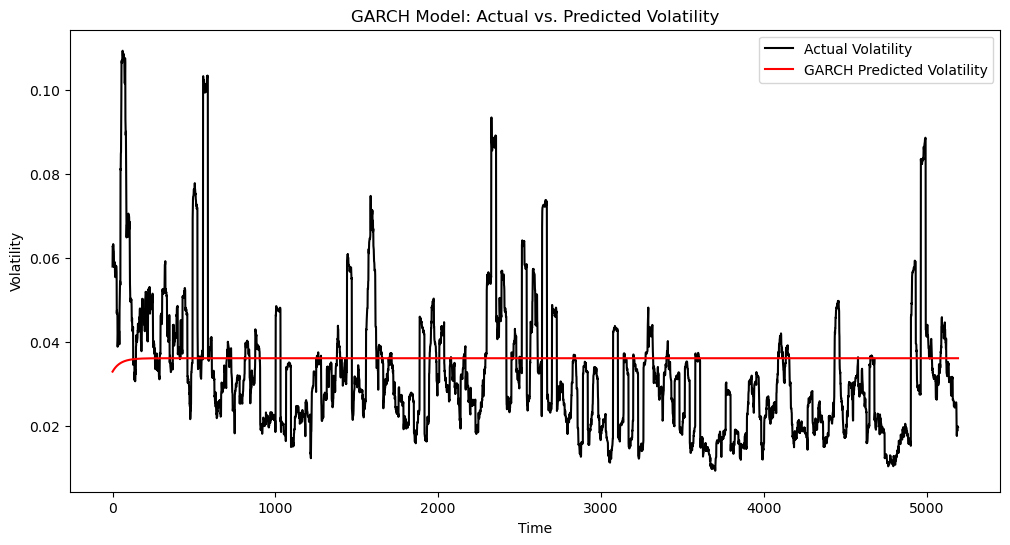

In [127]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_volatility, label='Actual Volatility', color='black')
plt.plot(forecast_garch, label='GARCH Predicted Volatility', color='red')
plt.title(f'GARCH Model: Actual vs. Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


# Actual vs. Predicted Volatility for LSTM Model

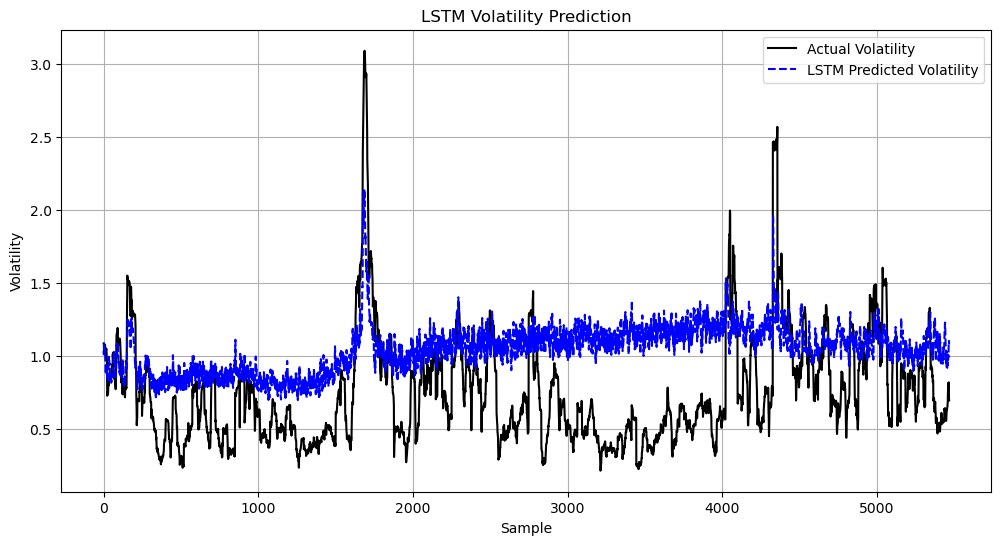

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Volatility', color='black', linestyle='-')
plt.plot(y_pred_inv, label='LSTM Predicted Volatility', color='blue', linestyle='--')
plt.title('LSTM Volatility Prediction')
plt.xlabel('Sample')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Actual vs. Predicted Volatility for Hybrid Model

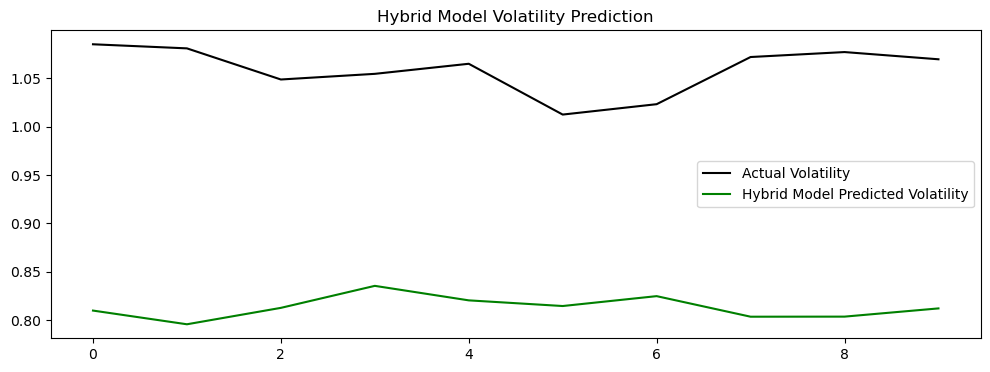

In [124]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv_trimmed, label='Actual Volatility', color='black')
plt.plot(hybrid_pred_trimmed, label='Hybrid Model Predicted Volatility', color='green')
plt.title('Hybrid Model Volatility Prediction')
plt.legend()
plt.show()



# Conclusion
In this project, we evaluated the performance of three different models for volatility prediction: GARCH, LSTM, and a Hybrid Model combining both approaches. We assessed their efficacy using various metrics, including RMSE, MAE, and Value at Risk (VaR). Below is a summary of our findings and conclusions based on these results:

# Model Performance

# 1.GARCH Model:

Root Mean Squared Error (RMSE): 0.0162

Mean Absolute Error (MAE): 0.0122

VaR for Next 10 Days: Ranges between -0.0390 and -0.0548

Analysis: The GARCH model demonstrates robust performance with the lowest RMSE and MAE among the models, indicating accurate volatility predictions. It also has relatively stable VaR predictions across different companies, which suggests reliable risk assessment.

# 2.LSTM Model:

Root Mean Squared Error (RMSE): 0.4449

Mean Absolute Error (MAE): 0.3748

Predicted vs. Actual Values: The LSTM model shows a significant discrepancy between predicted and actual values, with predictions being less accurate compared to GARCH.

Analysis: The LSTM model exhibits higher RMSE and MAE, indicating lower accuracy in volatility predictions. The deviations between predicted and actual values are substantial, suggesting that the LSTM model may struggle with volatility forecasting in this context.

# 3.Hybrid Model:

Root Mean Squared Error (RMSE): 0.2475

Mean Absolute Error (MAE): 0.2456

VaR for Next 10 Days: Ranges between -0.0355 and -0.0578

Investment Allocation: Provides a diversified investment allocation based on predicted volatilities and inverse VaR.

Analysis: The Hybrid Model improves upon LSTM's performance but does not reach the accuracy levels of the GARCH model. It offers a balanced approach that leverages both GARCH and LSTM predictions, resulting in moderate error metrics and reliable VaR calculations.

# Key Observations

Accuracy: The GARCH model consistently outperforms the other models in terms of prediction accuracy and error metrics, making it the preferred choice for volatility forecasting in this case.

Risk Assessment: The GARCH model provides reliable VaR estimates, which are crucial for understanding potential risk. The Hybrid Model also offers competitive VaR predictions, but the LSTM's performance in risk assessment is less reliable.

Investment Strategy: Based on the GARCH model, the optimal investment allocation is well-calibrated with the lowest VaR, suggesting efficient capital distribution with minimal risk. The Hybrid Model’s allocations are slightly less precise but still effective.

# Conclusion
The GARCH model is the most accurate and reliable for volatility prediction in this study, as evidenced by its superior RMSE, MAE, and consistent VaR estimates. The LSTM model, while useful in other contexts, shows less efficacy in volatility forecasting here. The Hybrid Model provides a balanced approach but falls short of the GARCH model's precision. For future applications, focusing on the GARCH model or further refining the Hybrid approach could enhance prediction accuracy and risk management.